# Analysis of human agreement

This notebook contains analysis for analyzing human agreement for the LMC paper and MT-Bench.

In [3]:
from datasets import load_dataset
import pandas as pd
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
import math
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from lm_council.constants import LLM_COUNCIL_MEMBERS
import os
from lm_council.analysis.pairwise.length_bias import get_num_words

# MT-Bench

In [6]:
dataset = load_dataset("lmsys/mt_bench_human_judgments")
df = dataset["human"].to_pandas()

In [7]:
df

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn
0,81,alpaca-13b,gpt-3.5-turbo,model_b,author_2,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,1
1,81,alpaca-13b,gpt-3.5-turbo,model_b,author_2,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,2
2,81,alpaca-13b,gpt-3.5-turbo,model_b,expert_17,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,1
3,81,alpaca-13b,gpt-3.5-turbo,model_b,expert_17,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,2
4,81,alpaca-13b,vicuna-13b-v1.2,model_b,expert_0,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,1
...,...,...,...,...,...,...,...,...
3350,160,vicuna-13b-v1.2,gpt-3.5-turbo,tie,author_4,[{'content': 'Suggest five award-winning docum...,[{'content': 'Suggest five award-winning docum...,2
3351,160,vicuna-13b-v1.2,gpt-3.5-turbo,model_b,expert_43,[{'content': 'Suggest five award-winning docum...,[{'content': 'Suggest five award-winning docum...,1
3352,160,vicuna-13b-v1.2,gpt-3.5-turbo,model_b,expert_43,[{'content': 'Suggest five award-winning docum...,[{'content': 'Suggest five award-winning docum...,2
3353,160,vicuna-13b-v1.2,llama-13b,model_a,expert_0,[{'content': 'Suggest five award-winning docum...,[{'content': 'Suggest five award-winning docum...,1


## How many judges were used?

MT-Bench has a varying # of human judges for each example.

   Number of Judges  Number of Examples  Percentage of Total Items
0                 1                1635                      68.24
1                 2                 599                      25.00
2                 3                 132                       5.51
3                 4                  24                       1.00
4                 5                   6                       0.25


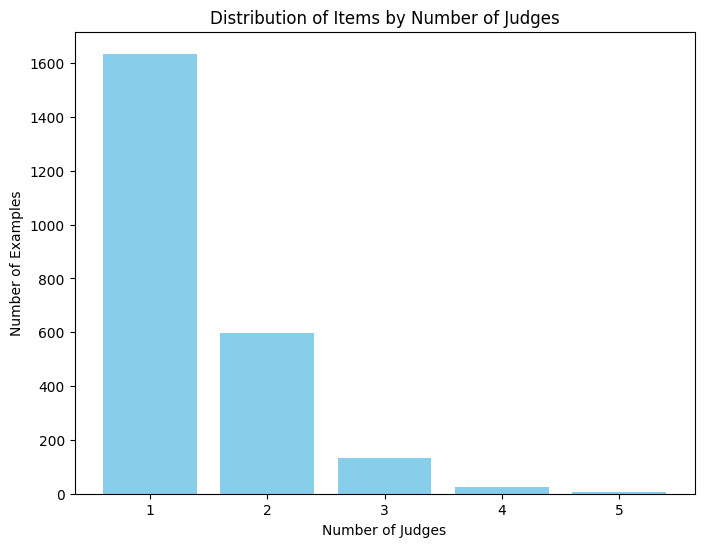

In [34]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Group the DataFrame by the specified keys
grouped = df.groupby(['question_id', 'model_a', 'model_b', 'turn'])

# Total number of unique keys
total_keys = grouped.ngroups

# Get the size of each group (number of judges per key)
group_sizes = grouped.size()

# Count the number of items for each possible number of judges
judge_counts = group_sizes.value_counts().sort_index()

# Create a DataFrame from judge_counts
judge_counts_df = pd.DataFrame({
    'Number of Judges': judge_counts.index,
    'Number of Examples': judge_counts.values
})

# Calculate the percentage of total items
judge_counts_df['Percentage of Total Items'] = (judge_counts_df['Number of Examples'] / total_keys) * 100

# Format the percentage to two decimal places
judge_counts_df['Percentage of Total Items'] = judge_counts_df['Percentage of Total Items'].round(2)

# Reorder columns if necessary
judge_counts_df = judge_counts_df[['Number of Judges', 'Number of Examples', 'Percentage of Total Items']]

# Display the DataFrame
print(judge_counts_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(judge_counts_df['Number of Judges'], judge_counts_df['Number of Examples'], color='skyblue')
plt.xlabel('Number of Judges')
plt.ylabel('Number of Examples')
plt.title('Distribution of Items by Number of Judges')
plt.xticks(judge_counts_df['Number of Judges'])
plt.show()

## Unanimity analysis

What percentage of examples were unanimous?

In [28]:
import pandas as pd

# Assuming 'df' is your original DataFrame

# Group the DataFrame by the specified keys
grouped = df.groupby(['question_id', 'model_a', 'model_b', 'turn'])

# Total number of unique keys
total_keys = grouped.ngroups

# Get the size of each group (number of judges per item)
group_sizes = grouped.size()

# Determine the number of unique 'winner' values in each group
unique_winners = grouped['winner'].nunique()

# Create a DataFrame to hold group statistics
group_stats = pd.DataFrame({
    'group_size': group_sizes,
    'unique_winners': unique_winners
})

# Classify each item as unanimous or non-unanimous
group_stats['is_unanimous'] = group_stats['unique_winners'] == 1

# Aggregate the data by group size
aggregate_stats = group_stats.groupby('group_size').agg(
    total_items=('is_unanimous', 'count'),
    unanimous_items=('is_unanimous', 'sum')
).reset_index()

# Calculate non-unanimous items and percentages
aggregate_stats['non_unanimous_items'] = aggregate_stats['total_items'] - aggregate_stats['unanimous_items']
aggregate_stats['pct_unanimous'] = (aggregate_stats['unanimous_items'] / aggregate_stats['total_items']) * 100
aggregate_stats['pct_non_unanimous'] = (aggregate_stats['non_unanimous_items'] / aggregate_stats['total_items']) * 100

# Format percentages
aggregate_stats['pct_unanimous'] = aggregate_stats['pct_unanimous'].round(2)
aggregate_stats['pct_non_unanimous'] = aggregate_stats['pct_non_unanimous'].round(2)

# Reorder columns for clarity
aggregate_stats = aggregate_stats[['group_size', 'total_items', 'unanimous_items', 'pct_unanimous', 'non_unanimous_items', 'pct_non_unanimous']]

# Display the DataFrame
print("Agreement Breakdown by Number of Judges:")
print(aggregate_stats)

Agreement Breakdown by Number of Judges:
   group_size  total_items  unanimous_items  pct_unanimous  \
0           1         1635             1635         100.00   
1           2          599              414          69.12   
2           3          132               55          41.67   
3           4           24                6          25.00   
4           5            6                4          66.67   

   non_unanimous_items  pct_non_unanimous  
0                    0               0.00  
1                  185              30.88  
2                   77              58.33  
3                   18              75.00  
4                    2              33.33  


## Item-wise agreement

In [35]:
def calculate_pairwise_agreement_percentage(votes):
    from itertools import combinations
    total_pairs = len(list(combinations(votes, 2)))
    
    # Iterate over all unique pairs of votes.
    agreeing_pairs = 0
    for vote1, vote2 in combinations(votes, 2):
        if vote1 == vote2:
            agreeing_pairs += 1

    return (agreeing_pairs / total_pairs) * 100

In [57]:
aggregated_votes = df.groupby(["question_id", "turn", "model_a", "model_b"])["winner"].agg(list)

pairwise_agreements = []
for votes in aggregated_votes:
    if len(votes) < 2:
        continue

    pairwise_agreements.append(calculate_pairwise_agreement_percentage(votes))

print(f"# examples with more than 1 vote: {len(pairwise_agreements)}")
print("Distribution of agreement:")
pd.DataFrame(pairwise_agreements).describe()

# examples with more than 1 vote: 761
Distribution of agreement:


,0
count,761.000000
mean,66.938239
std,44.310004
min,0.000000
25%,0.000000
50%,100.000000
75%,100.000000
max,100.000000


## Mode representation analysis

How representative is the majority vote?

In [58]:
def get_mode_representation_percentage(row):
    total_votes = sum([row["model_a"], row["model_b"], row["tie"]])
    if total_votes == 1:
        return None
    winning_item_num_votes = max([row["model_a"], row["model_b"], row["tie"]])
    if winning_item_num_votes == row["model_a"]:
        return row["model_a"] / total_votes
    elif winning_item_num_votes == row["model_b"]:
        return row["model_b"] / total_votes
    return row["tie"] / total_votes

In [62]:
x = df.groupby(["question_id", "model_a", "model_b", "turn"])["winner"].value_counts().unstack().fillna(0)
x["mode_representation"] = x.apply(get_mode_representation_percentage, axis=1)

print("How representative is the majority opinion?")
x["mode_representation"].describe()

How representative is the majority opinion?


count    761.000000
mean       0.831231
std        0.227245
min        0.333333
25%        0.500000
50%        1.000000
75%        1.000000
max        1.000000
Name: mode_representation, dtype: float64

## Visualization of length-based outcomes

In [75]:
def get_color(row):
    if row["winner"] == "model_a":
        return "royalblue"
    if row["winner"] == "model_b":
        return "orangered"
    return "teal"


df["conversation_a_num_tokens"] = df["conversation_a"].apply(lambda x: get_num_words(x[-1]["content"]))
df["conversation_b_num_tokens"] = df["conversation_b"].apply(lambda x: get_num_words(x[-1]["content"]))
df["color"] = df.apply(get_color, axis=1)

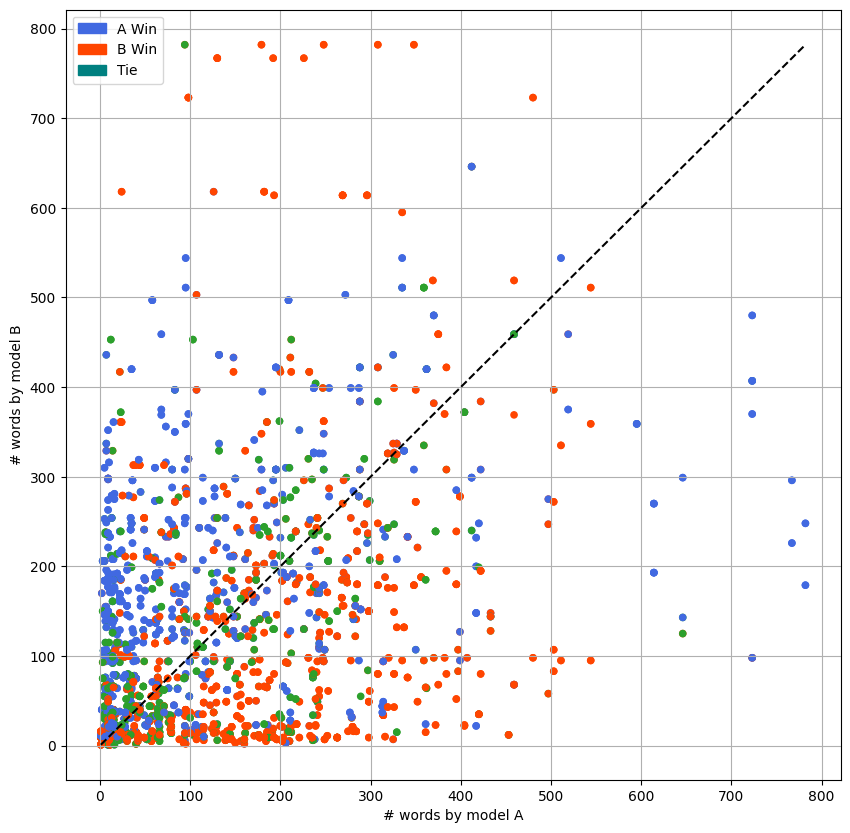

In [78]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 10))  # Set the figure size

plt.scatter(
    df['conversation_b_num_tokens'],  # X-axis data
    df['conversation_a_num_tokens'],   # Y-axis data
    color=df['color'],                       # Color by the 'color' column
    s=20
)

max_value = max(df['conversation_a_num_tokens'].max(), df['conversation_b_num_tokens'].max())
min_value = min(df['conversation_a_num_tokens'].min(), df['conversation_b_num_tokens'].min())
plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='Equal # tokens')  # 'k--' specifies a black dashed line

os.makedirs("analysis/human_agreement", exist_ok=True)

plt.xlabel('# words by model A')  # X-axis label
plt.ylabel('# words by model B')   # Y-axis label
plt.grid(True)    # Show grid lines

# Add custom legend for colors
legend_handles = [
    mpatches.Patch(color="royalblue", label="A Win"),
    mpatches.Patch(color="orangered", label="B Win"),
    mpatches.Patch(color="teal", label="Tie"),
]
plt.legend(handles=legend_handles)

plt.savefig("analysis/human_agreement/mt_bench_length_based_outcomes.pdf")

plt.show()        # Display the plot

In [80]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


# Calculate the difference in tokens
df.loc[:, 'token_diff'] = df['conversation_a_num_tokens'] - df['conversation_b_num_tokens']

def get_result_numeric(row):
    if row["winner"] == "model_a":
        return 1
    if row["winner"] == "model_b":
        return 0
    return 0

# Map the battle result to a numeric value.
df.loc[:, 'result_numeric'] = df.apply(get_result_numeric, axis=1)

def get_length_bias(df):
    # Calculate the difference in tokens
    df.loc[:, "token_diff"] = (
        df["conversation_a_num_tokens"] - df["conversation_b_num_tokens"]
    )
    df.loc[:, "result_numeric"] = df.apply(get_result_numeric, axis=1)

    X = df[["token_diff"]]
    y = df["result_numeric"]

    model = LinearRegression()
    model.fit(X, y)
    r_squared = model.score(X, y)

    print(r_squared)


get_length_bias(df)

0.049563352414311534


# Find agreement matrix between humans

In [155]:
# df = pd.read_csv("/Users/justinzhao/Downloads/Response Ratings - Sheet1.csv")
df = pd.read_csv("/Users/justinzhao/Downloads/data_for_j.csv")

In [156]:
len(df)

1343

In [157]:
def get_winner(value):
    if value == "Response A is slightly better":
        return "model_a"
    if value == "Response A much better than B":
        return "model_a"
    if value == "Response B much better than A":
        return "model_b"
    if value == "Response B is slightly better":
        return "model_b"
    raise ValueError(f"AH! Unaccounted value: {value}")
    

converted_df = df.rename(
    columns={
        "scenario_id": "question_id",
        "response_A_author": "model_a",
        "response_B_author": "model_b",
        "annotator_id": "judge",
    }
)

converted_df["turn"] = "0"
converted_df["winner"] = converted_df["response"].apply(get_winner)

In [158]:
df = converted_df

# Conversion to Council Leaderboard format

In [105]:
# council_leaderboard_format_df_sample = pd.read_json(
#     "/Users/justinzhao/Repos/llm-council/experiments/expansion.5_26/conversational_response_judging.100_to_200.qwen_32b_reference/sxs/consolidated_responses.jsonl",
#     lines=True,
#     orient="records"
# )
from lm_council.analysis.analyze_pairwise_ratings import get_judging_df_without_responses

In [106]:
council_leaderboard_format_df = get_judging_df_without_responses(
    "/Users/justinzhao/Repos/llm-council/experiments/expansion.5_26/conversational_response_judging.100_to_200.qwen_32b_reference/sxs/consolidated_responses.jsonl"
)

# council_leaderboard_format_df_sample.head(5)
# council_leaderboard_format_df_sample.iloc["metadata"]

In [59]:
council_leaderboard_format_df.head(5)

,id,llm_judge,judging_response_string,metadata,first_completion_by,second_completion_by,pairwise_choice
0,100,cohere://command-r-plus,Explanation: Both responses demonstrate empath...,{'completion_request': {'prompt_template_key':...,together://Qwen/Qwen1.5-32B-Chat,openai://gpt-4o-2024-05-13,B>A
1,102,cohere://command-r-plus,Explanation: Both responses exhibit authentici...,{'completion_request': {'prompt_template_key':...,anthropic://claude-3-sonnet-20240229,together://Qwen/Qwen1.5-32B-Chat,B>A
2,100,cohere://command-r-plus,Both responses demonstrate empathy and a clear...,{'completion_request': {'prompt_template_key':...,together://meta-llama/Llama-3-70b-chat-hf,together://Qwen/Qwen1.5-32B-Chat,A>B
3,100,cohere://command-r-plus,Both responses demonstrate empathy and offer a...,{'completion_request': {'prompt_template_key':...,together://Qwen/Qwen1.5-32B-Chat,cohere://command-r,A>B
4,102,cohere://command-r-plus,Explanation: Both responses exhibit authentici...,{'completion_request': {'prompt_template_key':...,together://Qwen/Qwen1.5-32B-Chat,vertex://gemini-1.0-pro,B>A


In [122]:
# df = pd.read_csv("/Users/justinzhao/Downloads/Response Ratings - Sheet1.csv")
df = pd.read_csv("/Users/justinzhao/Downloads/data_for_j.csv")

def get_winner_pairwise_choice(value):
    if value == "Response A is slightly better":
        # return "model_a"
        return "A>B"
    if value == "Response A much better than B":
        # return "model_a"
        return "A>B"
    if value == "Response B much better than A":
        # return "model_b"
        return "B>A"
    if value == "Response B is slightly better":
        # return "model_b"
        return "B>A"
    raise ValueError(f"AH! Unaccounted value: {value}")

converted_df = df.rename(
    columns={
        "scenario_id": "id",
        "response_A_author": "first_completion_by",
        "response_B_author": "second_completion_by",
        "annotator_id": "llm_judge",
    }
)

converted_df["pairwise_choice"] = converted_df["response"].apply(get_winner_pairwise_choice)
converted_df

,Unnamed: 0,id,id,llm_judge,session_id,response,response_A,first_completion_by,response_B,second_completion_by,...,u3,u4,action,clarity,concise,qualitative,winner,consistency,reject,pairwise_choice
0,0,57,20,5bd18be2718e24000181ada8,665b427ea90bed8f64b9242b,Response A much better than B,"It's tough to hear doubt from someone close, e...",openai://gpt-4o-2024-05-13,I understand that you're facing a tough dilemm...,openai://gpt-4-0613,...,False,False,True,False,False,NaN,openai://gpt-4o-2024-05-13,consistent,False,A>B
1,1,3,12,5bd18be2718e24000181ada8,665b427ea90bed8f64b9242b,Response A is slightly better,"Hi Andre, I'm sorry to hear you're going throu...",openai://gpt-4-0613,"I hear you Andre, and I'm sorry you're going t...",anthropic://claude-3-opus-20240229,...,False,False,True,False,False,NaN,openai://gpt-4-0613,consistent,False,A>B
2,2,67,21,5bd18be2718e24000181ada8,665b427ea90bed8f64b9242b,Response B much better than A,I understand that you’re feeling a lot of angs...,openai://gpt-4-0613,Here's how I would respond to this person in a...,anthropic://claude-3-haiku-20240307,...,False,False,False,False,False,NaN,anthropic://claude-3-haiku-20240307,consistent,False,B>A
3,3,55,16,5bd18be2718e24000181ada8,665b427ea90bed8f64b9242b,Response A much better than B,"I understand your predicament, and it's a deli...",mistral://open-mixtral-8x7b,It sounds like a tricky predicament. Communica...,openai://gpt-4-0613,...,False,False,True,True,True,NaN,mistral://open-mixtral-8x7b,consistent,False,A>B
4,4,65,19,5bd18be2718e24000181ada8,665b427ea90bed8f64b9242b,Response B is slightly better,"It sounds like a tricky situation. However, it...",openai://gpt-4-0613,Here's how I would respond to this person:\n\n...,anthropic://claude-3-haiku-20240307,...,False,False,False,False,False,NaN,anthropic://claude-3-haiku-20240307,consistent,False,B>A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,1691,117,192,5d8cb1c93a7d5c00196eae92,665debb17742904de42a86eb,Response B is slightly better,I understand how frustrating and disheartening...,together://Qwen/Qwen1.5-32B-Chat,I'm sorry to hear about the difficulty you're ...,mistral://open-mixtral-8x7b,...,True,True,False,False,False,NaN,mistral://open-mixtral-8x7b,consistent,False,B>A
1339,1692,81,154,5d8cb1c93a7d5c00196eae92,665debb17742904de42a86eb,Response B much better than A,It's understandable that you're feeling a bit失...,together://Qwen/Qwen1.5-32B-Chat,Here is my 250-word response to the person see...,anthropic://claude-3-haiku-20240307,...,False,False,False,False,False,NaN,anthropic://claude-3-haiku-20240307,consistent,False,B>A
1340,1693,15,120,59e39cc9c0d35a0001294f20,665debb1c6ad4dfe14b24e21,Response A is slightly better,I would respond to this person with the follow...,anthropic://claude-3-haiku-20240307,It's understandable that you're feeling draine...,together://Qwen/Qwen1.5-32B-Chat,...,False,True,True,True,False,NaN,anthropic://claude-3-haiku-20240307,consistent,False,A>B
1341,1695,39,191,5d8cb1c93a7d5c00196eae92,665debb17742904de42a86eb,Response B is slightly better,"I understand this is a challenging situation, ...",anthropic://claude-3-haiku-20240307,I understand how challenging it can be to navi...,together://Qwen/Qwen1.5-32B-Chat,...,False,False,True,True,True,NaN,together://Qwen/Qwen1.5-32B-Chat,consistent,False,B>A


In [123]:
from lm_council.analysis.analyze_pairwise_ratings import terry_bradley_analysis

In [124]:
terry_bradley_analysis(converted_df, "/Users/justinzhao/Repos/llm-council/experiments/expansion.5_26/human_ratings")

In [125]:
from lm_council.analysis.analyze_pairwise_ratings import analyze_separability

analyze_separability(
    converted_df, 
    "/Users/justinzhao/Repos/llm-council/experiments/expansion.5_26/human_ratings2",
    "together://Qwen/Qwen1.5-32B-Chat",
    None,
    100,
)

bootstrap: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.76it/s]


Expected win rates for full council, without aggregation.
claude-3-opus                  | score: 55.7  | 95% CI: (-6.1, 5.0) 
gpt-4o-2024-05-13              | score: 54.0  | 95% CI: (-5.2, 7.4) 
qwen1.5-110B-Chat              | score: 53.0  | 95% CI: (-7.4, 6.6) 
qwen1.5-32B-Chat               | score: 50.0  | 95% CI:  (0.0, 0.0) 
llama-3-70b-chat               | score: 49.7  | 95% CI: (-7.1, 8.4) 
claude-3-haiku                 | score: 49.0  | 95% CI: (-6.0, 5.5) 
mixtral-8x7b                   | score: 48.9  | 95% CI: (-4.6, 5.3) 
gpt-4-0613                     | score: 44.2  | 95% CI: (-6.3, 6.2) 
llama-3-8b-chat                | score: 40.0  | 95% CI: (-15.9, 13.5)


ValueError: Grouper for 'id' not 1-dimensional

# Rank graph

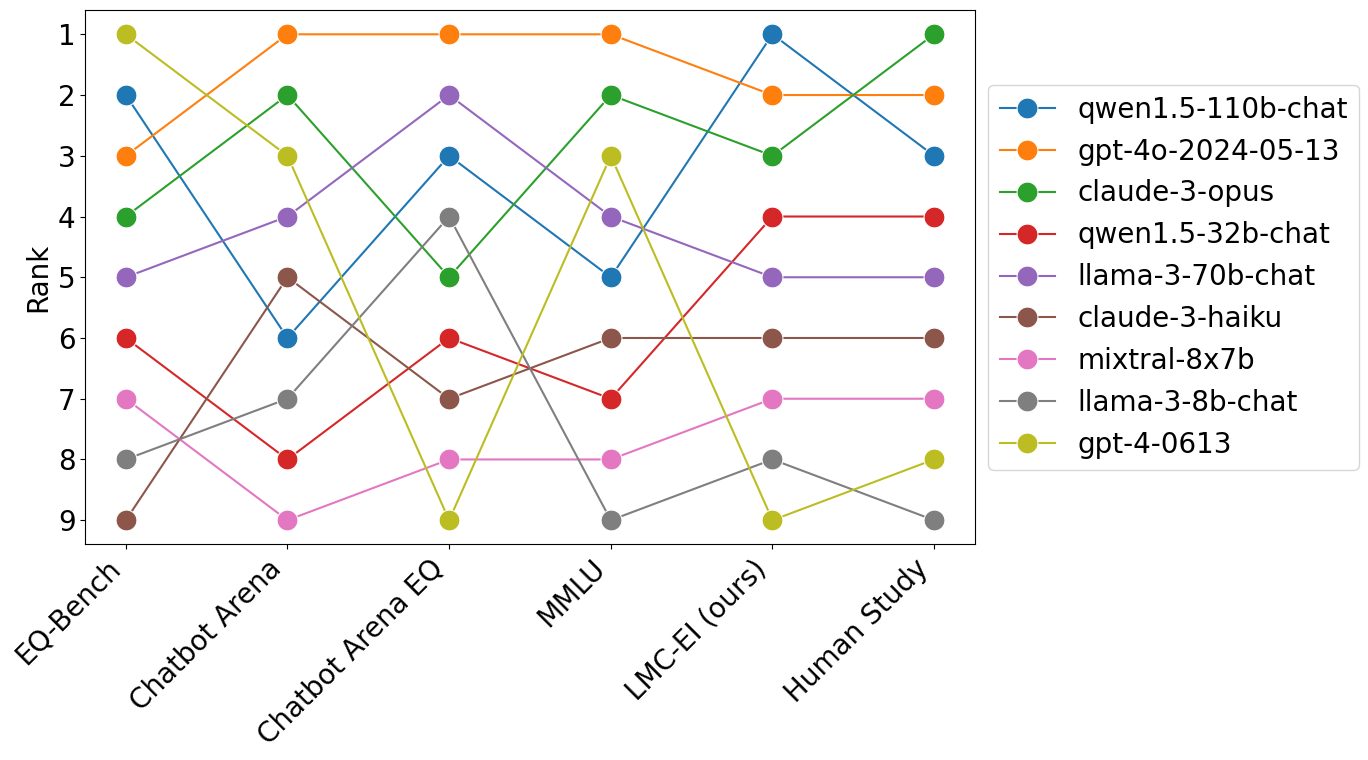

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set font size as a variable
font_size = 20

# Set global font size using the variable
plt.rcParams.update({'font.size': font_size})

# Sample DataFrame (replace with your data)
df = pd.read_csv("/Users/justinzhao/Downloads/Language Model Council (LLM EQ Leaderboard) - Comparison to other Leaderboards.csv")
df["System"] = df["System"].apply(lambda x: "Chatbot Arena EQ" if x == "Chatbot Arena mined EQ subset (n=100)" else x)
df["LLM"] = df["LLM"].apply(lambda x: x.lower())

# Define the order of the 'System' column
system_order = ["EQ-Bench", "Chatbot Arena", "Chatbot Arena EQ", "MMLU", "LMC-EI (ours)", "Human Study"]

# Convert the 'System' column to a categorical type with the specified order
df['System'] = pd.Categorical(df['System'], categories=system_order, ordered=True)

# Create the plot
plt.figure(figsize=(14, 8))
sns.lineplot(x='System', y='Rank', hue='LLM', data=df, marker='o', markersize=15)

# Add labels and title with font size referenced from the variable
plt.xlabel('', fontsize=font_size)
plt.ylabel('Rank', fontsize=font_size)
plt.xticks(fontsize=font_size, rotation=45, ha='right')
plt.yticks(fontsize=font_size)

# Customize appearance
plt.gca().invert_yaxis()  # Rank 1 should be at the top

# Show the plot
plt.legend(title="", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=font_size)
plt.tight_layout()
plt.savefig("/Users/justinzhao/Repos/llm-council-public/analysis/human_ranking_comparison.pdf")
plt.show()


# START OF AGREEMENT CALCULATION

In [159]:
# Total number of judges:
len(df["judge"].unique())

102

In [160]:
# The actual judges
df["judge"].unique()

array(['5bd18be2718e24000181ada8', '6658d55cfc0ff7bc3cf8a42e',
       '5d76b0ac7aa70c001ba3dc55', '665897e9df26bb82cc72f010',
       '60fd533ec72b96e7ba6c2a50', '60ca044c7b2e9a4654efeb77',
       '62d81f26161631255f0d36bd', '5f84e472052cf81ae5752252',
       '5e8fc56be9fe622b8bd9069b', '5f5e32a0d6a12c6857b8e127',
       '665b20b3b0db636843b77ea0', '663a987fa23dfe6c8682c93a',
       '5cebd58ade266200191eaf7d', '66337987220de404794cb171',
       '600eccf35bb4996e7d3c694f', '6658b6a9ef238c82f61cd21a',
       '60cf5ca7f7689965b747007c', '60cba2cdd2fb6c8899081827',
       '5bbc94bc4b3b020001ba5f93', '662fcd17b20d5b9c6118e801',
       '5cbcc928ec9b730018bad2a9', '5d544ce3be713b0001841f1e',
       '613cb18edb7eb18d77d8d1e1', '5ed519d5f242dd06a51883e7',
       '63d7cca3604b6ac41db6b73f', '5baa685207b344000128ea01',
       '63e55111b99779f818559ad8', '6658b5a9f69162ea286e402f',
       '5f077fdf5f079b3961a02ad1', '6637c51a6a56c083fff5250a',
       '631748d718be5f44496bf754', '6659ff7645db8e16a43

In [161]:
judge_to_votes_map = defaultdict(dict)
for i, row in df.iterrows():
    judge_to_votes_map[row["judge"]][(row["question_id"], row["turn"], row["model_a"], row["model_b"])] = row["winner"]

In [ ]:
from sklearn.metrics import cohen_kappa_score

# def get_judge_to_judge_agreement(judge1_votes, judge2_votes):
#     agreements = []
#     judge1_vote_keys = set(judge1_votes.keys())
#     judge2_vote_keys = set(judge2_votes.keys())

#     both_judge_vote_keys = judge1_vote_keys & judge2_vote_keys

#     if not both_judge_vote_keys:
#         return None

#     for judge_vote_key in both_judge_vote_keys:
#         agreements.append(judge1_votes[judge_vote_key] == judge2_votes[judge_vote_key])

#     return np.mean(agreements)

def get_judge_to_judge_agreement(judge1_votes, judge2_votes, method):
    agreements = []
    judge1_vote_keys = set(judge1_votes.keys())
    judge2_vote_keys = set(judge2_votes.keys())

    # After removing inconsistent votes, it's possible that many votes are non-overlapping.
    both_judge_vote_keys = judge1_vote_keys & judge2_vote_keys

    if not both_judge_vote_keys:
        return None

    # Extract the responses from both judges
    responses_judge1 = [judge1_votes[qid] for qid in both_judge_vote_keys]
    responses_judge2 = [judge2_votes[qid] for qid in both_judge_vote_keys]
    if method == "cohen_kappa":
        return cohen_kappa_score(
            responses_judge1,
            responses_judge2,
            # labels=["model_a", "model_b"],
            labels=["model_a", "model_b", "tie"],
        )
    elif method == "exact":
        num_agreeements = 0
        for response_judge1, response_judge2 in zip(responses_judge1, responses_judge2):
            if response_judge1 == response_judge2:
                num_agreeements += 1
        return num_agreeements / len(responses_judge1)
    else:
        raise ValueError(f"Unknown judge_to_judge_agreement method: {method}")

# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    for judge2 in df["judge"].unique():
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "cohen_kappa")
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement


In [166]:
# Find the average agreement between two judges.
agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        agreements.append(agreement)

pd.DataFrame(agreements).describe()

,0
count,1934.000000
mean,0.023430
std,0.369193
min,-1.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

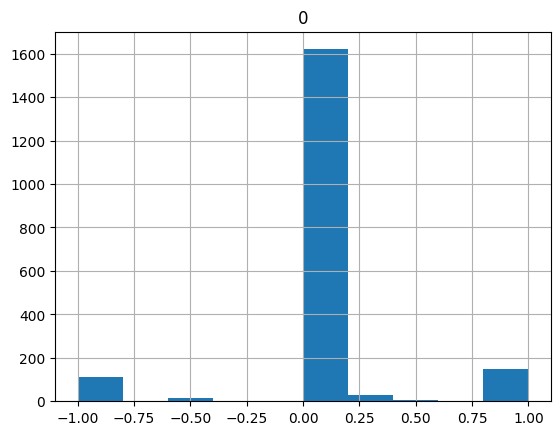

In [167]:
pd.DataFrame(agreements).hist()

# Agreement between humans and LLMs.

In [201]:
council_df = get_judging_df_without_responses(
    "/Users/justinzhao/Repos/llm-council/experiments/expansion.5_26/conversational_response_judging.100_to_200.qwen_32b_reference/sxs/consolidated_responses.jsonl"
)

In [202]:
def get_winner(value):
    if value in ["B>A", "B>>A"]:
        return "model_b"
    if value in ["A>B", "A>>B"]:
        return "model_a"
    if value in ["A=B"]:
        return "tie"
    raise ValueError(f"AH! Unaccounted value: {value}")

converted_council_df = council_df.rename(
    columns={
        "id": "question_id",
        "first_completion_by": "model_a",
        "second_completion_by": "model_b",
        "llm_judge": "judge",
    }
)

converted_council_df["turn"] = "0"
converted_council_df["winner"] = converted_council_df["pairwise_choice"].apply(get_winner)
council_df = converted_council_df
council_df

,question_id,judge,judging_response_string,metadata,model_a,model_b,pairwise_choice,turn,winner
0,100,cohere://command-r-plus,Explanation: Both responses demonstrate empath...,{'completion_request': {'prompt_template_key':...,together://Qwen/Qwen1.5-32B-Chat,openai://gpt-4o-2024-05-13,B>A,0,model_b
1,102,cohere://command-r-plus,Explanation: Both responses exhibit authentici...,{'completion_request': {'prompt_template_key':...,anthropic://claude-3-sonnet-20240229,together://Qwen/Qwen1.5-32B-Chat,B>A,0,model_b
2,100,cohere://command-r-plus,Both responses demonstrate empathy and a clear...,{'completion_request': {'prompt_template_key':...,together://meta-llama/Llama-3-70b-chat-hf,together://Qwen/Qwen1.5-32B-Chat,A>B,0,model_a
3,100,cohere://command-r-plus,Both responses demonstrate empathy and offer a...,{'completion_request': {'prompt_template_key':...,together://Qwen/Qwen1.5-32B-Chat,cohere://command-r,A>B,0,model_a
4,102,cohere://command-r-plus,Explanation: Both responses exhibit authentici...,{'completion_request': {'prompt_template_key':...,together://Qwen/Qwen1.5-32B-Chat,vertex://gemini-1.0-pro,B>A,0,model_b
...,...,...,...,...,...,...,...,...,...
75995,199,openai://gpt-4-turbo-2024-04-09,Both responses offer empathetic and actionable...,{'completion_request': {'prompt_template_key':...,together://Qwen/Qwen1.5-32B-Chat,anthropic://claude-3-haiku-20240307,A>B,0,model_a
75996,199,openai://gpt-4-turbo-2024-04-09,Both responses offer thoughtful advice and dem...,{'completion_request': {'prompt_template_key':...,openai://gpt-3.5-turbo-0125,together://Qwen/Qwen1.5-32B-Chat,B>A,0,model_b
75997,199,openai://gpt-4-turbo-2024-04-09,Both responses provide thoughtful and empathet...,{'completion_request': {'prompt_template_key':...,together://Qwen/Qwen1.5-32B-Chat,openai://gpt-4o-2024-05-13,A>B,0,model_a
75998,199,openai://gpt-4-turbo-2024-04-09,Both responses offer thoughtful and empathetic...,{'completion_request': {'prompt_template_key':...,together://Qwen/Qwen1.5-32B-Chat,openai://gpt-4-turbo-2024-04-09,A>B,0,model_a


In [246]:
df = pd.read_csv("/Users/justinzhao/Downloads/data_for_j.csv")

def get_winner(value):
    if value == "Response A is slightly better":
        return "model_a"
    if value == "Response A much better than B":
        return "model_a"
    if value == "Response B much better than A":
        return "model_b"
    if value == "Response B is slightly better":
        return "model_b"
    raise ValueError(f"AH! Unaccounted value: {value}")
    

converted_df = df.rename(
    columns={
        "scenario_id": "question_id",
        "response_A_author": "model_a",
        "response_B_author": "model_b",
        "annotator_id": "judge",
    }
)

converted_df["turn"] = "0"
converted_df["winner"] = converted_df["response"].apply(get_winner)
df = converted_df
df

,Unnamed: 0,id,question_id,judge,session_id,response,response_A,model_a,response_B,model_b,...,u3,u4,action,clarity,concise,qualitative,winner,consistency,reject,turn
0,0,57,20,5bd18be2718e24000181ada8,665b427ea90bed8f64b9242b,Response A much better than B,"It's tough to hear doubt from someone close, e...",openai://gpt-4o-2024-05-13,I understand that you're facing a tough dilemm...,openai://gpt-4-0613,...,False,False,True,False,False,NaN,model_a,consistent,False,0
1,1,3,12,5bd18be2718e24000181ada8,665b427ea90bed8f64b9242b,Response A is slightly better,"Hi Andre, I'm sorry to hear you're going throu...",openai://gpt-4-0613,"I hear you Andre, and I'm sorry you're going t...",anthropic://claude-3-opus-20240229,...,False,False,True,False,False,NaN,model_a,consistent,False,0
2,2,67,21,5bd18be2718e24000181ada8,665b427ea90bed8f64b9242b,Response B much better than A,I understand that you’re feeling a lot of angs...,openai://gpt-4-0613,Here's how I would respond to this person in a...,anthropic://claude-3-haiku-20240307,...,False,False,False,False,False,NaN,model_b,consistent,False,0
3,3,55,16,5bd18be2718e24000181ada8,665b427ea90bed8f64b9242b,Response A much better than B,"I understand your predicament, and it's a deli...",mistral://open-mixtral-8x7b,It sounds like a tricky predicament. Communica...,openai://gpt-4-0613,...,False,False,True,True,True,NaN,model_a,consistent,False,0
4,4,65,19,5bd18be2718e24000181ada8,665b427ea90bed8f64b9242b,Response B is slightly better,"It sounds like a tricky situation. However, it...",openai://gpt-4-0613,Here's how I would respond to this person:\n\n...,anthropic://claude-3-haiku-20240307,...,False,False,False,False,False,NaN,model_b,consistent,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,1691,117,192,5d8cb1c93a7d5c00196eae92,665debb17742904de42a86eb,Response B is slightly better,I understand how frustrating and disheartening...,together://Qwen/Qwen1.5-32B-Chat,I'm sorry to hear about the difficulty you're ...,mistral://open-mixtral-8x7b,...,True,True,False,False,False,NaN,model_b,consistent,False,0
1339,1692,81,154,5d8cb1c93a7d5c00196eae92,665debb17742904de42a86eb,Response B much better than A,It's understandable that you're feeling a bit失...,together://Qwen/Qwen1.5-32B-Chat,Here is my 250-word response to the person see...,anthropic://claude-3-haiku-20240307,...,False,False,False,False,False,NaN,model_b,consistent,False,0
1340,1693,15,120,59e39cc9c0d35a0001294f20,665debb1c6ad4dfe14b24e21,Response A is slightly better,I would respond to this person with the follow...,anthropic://claude-3-haiku-20240307,It's understandable that you're feeling draine...,together://Qwen/Qwen1.5-32B-Chat,...,False,True,True,True,False,NaN,model_a,consistent,False,0
1341,1695,39,191,5d8cb1c93a7d5c00196eae92,665debb17742904de42a86eb,Response B is slightly better,"I understand this is a challenging situation, ...",anthropic://claude-3-haiku-20240307,I understand how challenging it can be to navi...,together://Qwen/Qwen1.5-32B-Chat,...,False,False,True,True,True,NaN,model_b,consistent,False,0


In [261]:
human_rated_ids = df.drop_duplicates(subset=["question_id", "model_a", "model_b", "turn"])
# df["question_id", "model_a", "model_b", "turn"].unique()
# df

In [262]:
human_rated_ids
human_rated_id_set = set()
for i, row in human_rated_ids.iterrows():
    human_rated_id_set.add((row["question_id"], row["turn"], row["model_a"], row["model_b"]))

In [263]:
combined_df = pd.concat([df, council_df])
df = combined_df

In [264]:
council_df_majority_votes = (
    council_df.groupby(["question_id", "turn", "model_a", "model_b"])
    .agg(
        winner=pd.NamedAgg(
            column="winner", aggfunc=lambda x: x.mode()[0]
        )
    )
    .reset_index()
)


In [232]:
# council_df_majority_votes

,question_id,turn,model_a,model_b,winner
0,100,0,anthropic://claude-3-haiku-20240307,together://Qwen/Qwen1.5-32B-Chat,model_a
1,100,0,anthropic://claude-3-opus-20240229,together://Qwen/Qwen1.5-32B-Chat,model_b
2,100,0,anthropic://claude-3-sonnet-20240229,together://Qwen/Qwen1.5-32B-Chat,model_b
3,100,0,cohere://command-r,together://Qwen/Qwen1.5-32B-Chat,model_b
4,100,0,cohere://command-r-plus,together://Qwen/Qwen1.5-32B-Chat,model_a
...,...,...,...,...,...
3795,199,0,together://databricks/dbrx-instruct,together://Qwen/Qwen1.5-32B-Chat,model_a
3796,199,0,together://meta-llama/Llama-3-70b-chat-hf,together://Qwen/Qwen1.5-32B-Chat,model_a
3797,199,0,together://meta-llama/Llama-3-8b-chat-hf,together://Qwen/Qwen1.5-32B-Chat,model_a
3798,199,0,vertex://gemini-1.0-pro,together://Qwen/Qwen1.5-32B-Chat,model_a


In [265]:
judge_to_votes_map = defaultdict(dict)
for i, row in df.iterrows():
    judge_to_votes_map[row["judge"]][(row["question_id"], row["turn"], row["model_a"], row["model_b"])] = row["winner"]

# Add Council.
for i, row in council_df_majority_votes.iterrows():
    judge_to_votes_map["council"][(row["question_id"], row["turn"], row["model_a"], row["model_b"])] = row["winner"]

from sklearn.metrics import cohen_kappa_score

def get_judge_to_judge_agreement(judge1_votes, judge2_votes, method):
    agreements = []
    judge1_vote_keys = set(judge1_votes.keys())
    judge2_vote_keys = set(judge2_votes.keys())

    # After removing inconsistent votes, it's possible that many votes are non-overlapping.
    both_judge_vote_keys = judge1_vote_keys & judge2_vote_keys & human_rated_id_set

    if not both_judge_vote_keys:
        return None

    # Extract the responses from both judges
    responses_judge1 = [judge1_votes[qid] for qid in both_judge_vote_keys]
    responses_judge2 = [judge2_votes[qid] for qid in both_judge_vote_keys]
    if method == "cohen_kappa":
        return cohen_kappa_score(
            responses_judge1,
            responses_judge2,
            # labels=["model_a", "model_b"],
            labels=["model_a", "model_b", "tie"],
        )
    elif method == "exact":
        num_agreeements = 0
        for response_judge1, response_judge2 in zip(responses_judge1, responses_judge2):
            if response_judge1 == response_judge2:
                num_agreeements += 1
        return num_agreeements / len(responses_judge1)
    else:
        raise ValueError(f"Unknown judge_to_judge_agreement method: {method}")

# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    for judge2 in df["judge"].unique():
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "cohen_kappa")
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement

# Add council
for judge2 in df["judge"].unique():
    judge1_votes = judge_to_votes_map["council"]
    judge2_votes = judge_to_votes_map[judge2]

    # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
    agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
    # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "cohen_kappa")
    if agreement is not None:
        judge_to_judge_agreement[judge1][judge2] = agreement


# Find the average agreement between two judges.
non_matches = 0
agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        if "://" in judge and "://" not in other_judge and "council://" not in judge:
            agreements.append(agreement)
        elif "://" in other_judge and "://" not in judge and "council://" not in other_judge:
            agreements.append(agreement)
        else:
            non_matches += 1

print("Exact agreement between humans and Council (all)")
print(non_matches)
pd.DataFrame(agreements).describe()

Exact agreement between humans and Council (all)
3591


,0
count,3360.000000
mean,0.522911
std,0.155401
min,0.000000
25%,0.416667
50%,0.523810
75%,0.636364
max,1.000000


In [236]:
# judge_to_votes_map["mistral://mistral-large-latest"]
judge_to_judge_agreement["council"]

{}

In [267]:
# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    for judge2 in df["judge"].unique():
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "cohen_kappa")
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement


# Find the average agreement between two judges.
non_matches = 0
agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        if "://" in judge and "://" in other_judge and "council://" not in judge and "council://" not in other_judge:
            agreements.append(agreement)
        else:
            non_matches += 1

print("Exact agreement between Council (all) and Council (all)")
print(non_matches)
pd.DataFrame(agreements).describe()

Exact agreement between Council (all) and Council (all)
6570


,0
count,380.000000
mean,0.563534
std,0.130510
min,0.180672
25%,0.466387
50%,0.581933
75%,0.672269
max,0.819328


In [275]:
# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    for judge2 in df["judge"].unique():
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "cohen_kappa")
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement

# Add council
for judge2 in df["judge"].unique():
    judge1_votes = judge_to_votes_map["council"]
    judge2_votes = judge_to_votes_map[judge2]
    agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
    if agreement is not None:
        judge_to_judge_agreement["council"][judge2] = agreement


# Find the average agreement between two judges.
non_matches = 0
agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        if judge == "openai://gpt-4o-2024-05-13" and "://" in other_judge and "council://" not in other_judge:
            agreements.append(agreement)
        elif other_judge == "openai://gpt-4o-2024-05-13" and "://" in judge and "council://" not in judge:
            agreements.append(agreement)
        else:
            non_matches += 1

print("Exact agreement between GPT-4o and Council (all)")
print(non_matches)
pd.DataFrame(agreements).describe()

Exact agreement between GPT-4o and Council (all)
7016


,0
count,38.000000
mean,0.602167
std,0.131606
min,0.357143
25%,0.478992
50%,0.672269
75%,0.707983
max,0.752101


In [276]:
# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    for judge2 in df["judge"].unique():
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "cohen_kappa")
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement

# Add council
for judge2 in df["judge"].unique():
    judge1_votes = judge_to_votes_map["council"]
    judge2_votes = judge_to_votes_map[judge2]
    agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
    if agreement is not None:
        judge_to_judge_agreement["council"][judge2] = agreement


# Find the average agreement between two judges.
non_matches = 0
agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        if judge == "openai://gpt-4o-2024-05-13" and "council" == other_judge:
            agreements.append(agreement)
        elif other_judge == "openai://gpt-4o-2024-05-13" and "council" == judge:
            agreements.append(agreement)
        else:
            non_matches += 1

print("Exact agreement between GPT-4o and Council majority")
print(non_matches)
pd.DataFrame(agreements).describe()

Exact agreement between GPT-4o and Council majority
7053


,0
count,1.000000
mean,0.785714
std,NaN
min,0.785714
25%,0.785714
50%,0.785714
75%,0.785714
max,0.785714


In [277]:
# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    for judge2 in df["judge"].unique():
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "cohen_kappa")
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement

# Add council
for judge2 in df["judge"].unique():
    judge1_votes = judge_to_votes_map["council"]
    judge2_votes = judge_to_votes_map[judge2]
    agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
    if agreement is not None:
        judge_to_judge_agreement["council"][judge2] = agreement


# Find the average agreement between two judges.
non_matches = 0
agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        if "://" in judge and "council" == other_judge:
            agreements.append(agreement)
        elif "://" in other_judge and "council" == judge:
            agreements.append(agreement)
        else:
            non_matches += 1

print("Exact agreement LLMs and Council majority")
print(non_matches)
pd.DataFrame(agreements).describe()

Exact agreement LLMs and Council majority
7034


,0
count,20.000000
mean,0.673739
std,0.094143
min,0.474790
25%,0.619748
50%,0.701681
75%,0.747899
max,0.785714


In [278]:
# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    for judge2 in df["judge"].unique():
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "cohen_kappa")
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement

# Add council
for judge2 in df["judge"].unique():
    judge1_votes = judge_to_votes_map["council"]
    judge2_votes = judge_to_votes_map[judge2]
    agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
    if agreement is not None:
        judge_to_judge_agreement["council"][judge2] = agreement


# Find the average agreement between two judges.
non_matches = 0
agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        if "://" not in judge and judge != "council" and "council" == other_judge:
            agreements.append(agreement)
        elif "://" not in other_judge and other_judge != "council" and "council" == judge:
            agreements.append(agreement)
        else:
            non_matches += 1

print("Exact agreement human and Council majority")
print(non_matches)
pd.DataFrame(agreements).describe()

Exact agreement human and Council majority
6970


,0
count,84.000000
mean,0.542344
std,0.156610
min,0.181818
25%,0.454545
50%,0.545455
75%,0.654167
max,0.833333


In [279]:
# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    for judge2 in df["judge"].unique():
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "exact")
        # agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes, "cohen_kappa")
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement


# Find the average agreement between two judges.
non_matches = 0
agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        if judge == "openai://gpt-4o-2024-05-13" and "://" not in other_judge:
            agreements.append(agreement)
        elif other_judge == "openai://gpt-4o-2024-05-13" and "://" not in judge:
            agreements.append(agreement)
        else:
            non_matches += 1

print("Exact agreement between GPT-4o and Human")
print(non_matches)
pd.DataFrame(agreements).describe()

Exact agreement between GPT-4o and Human
6782


,0
count,168.000000
mean,0.514255
std,0.161978
min,0.100000
25%,0.400000
50%,0.500000
75%,0.617788
max,1.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

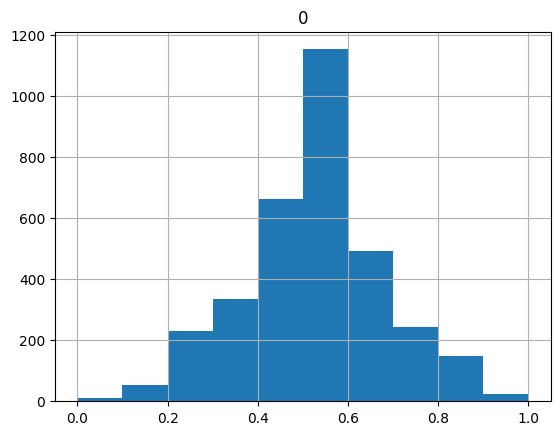

In [153]:
pd.DataFrame(agreements).hist()

## Only count non-tie votes

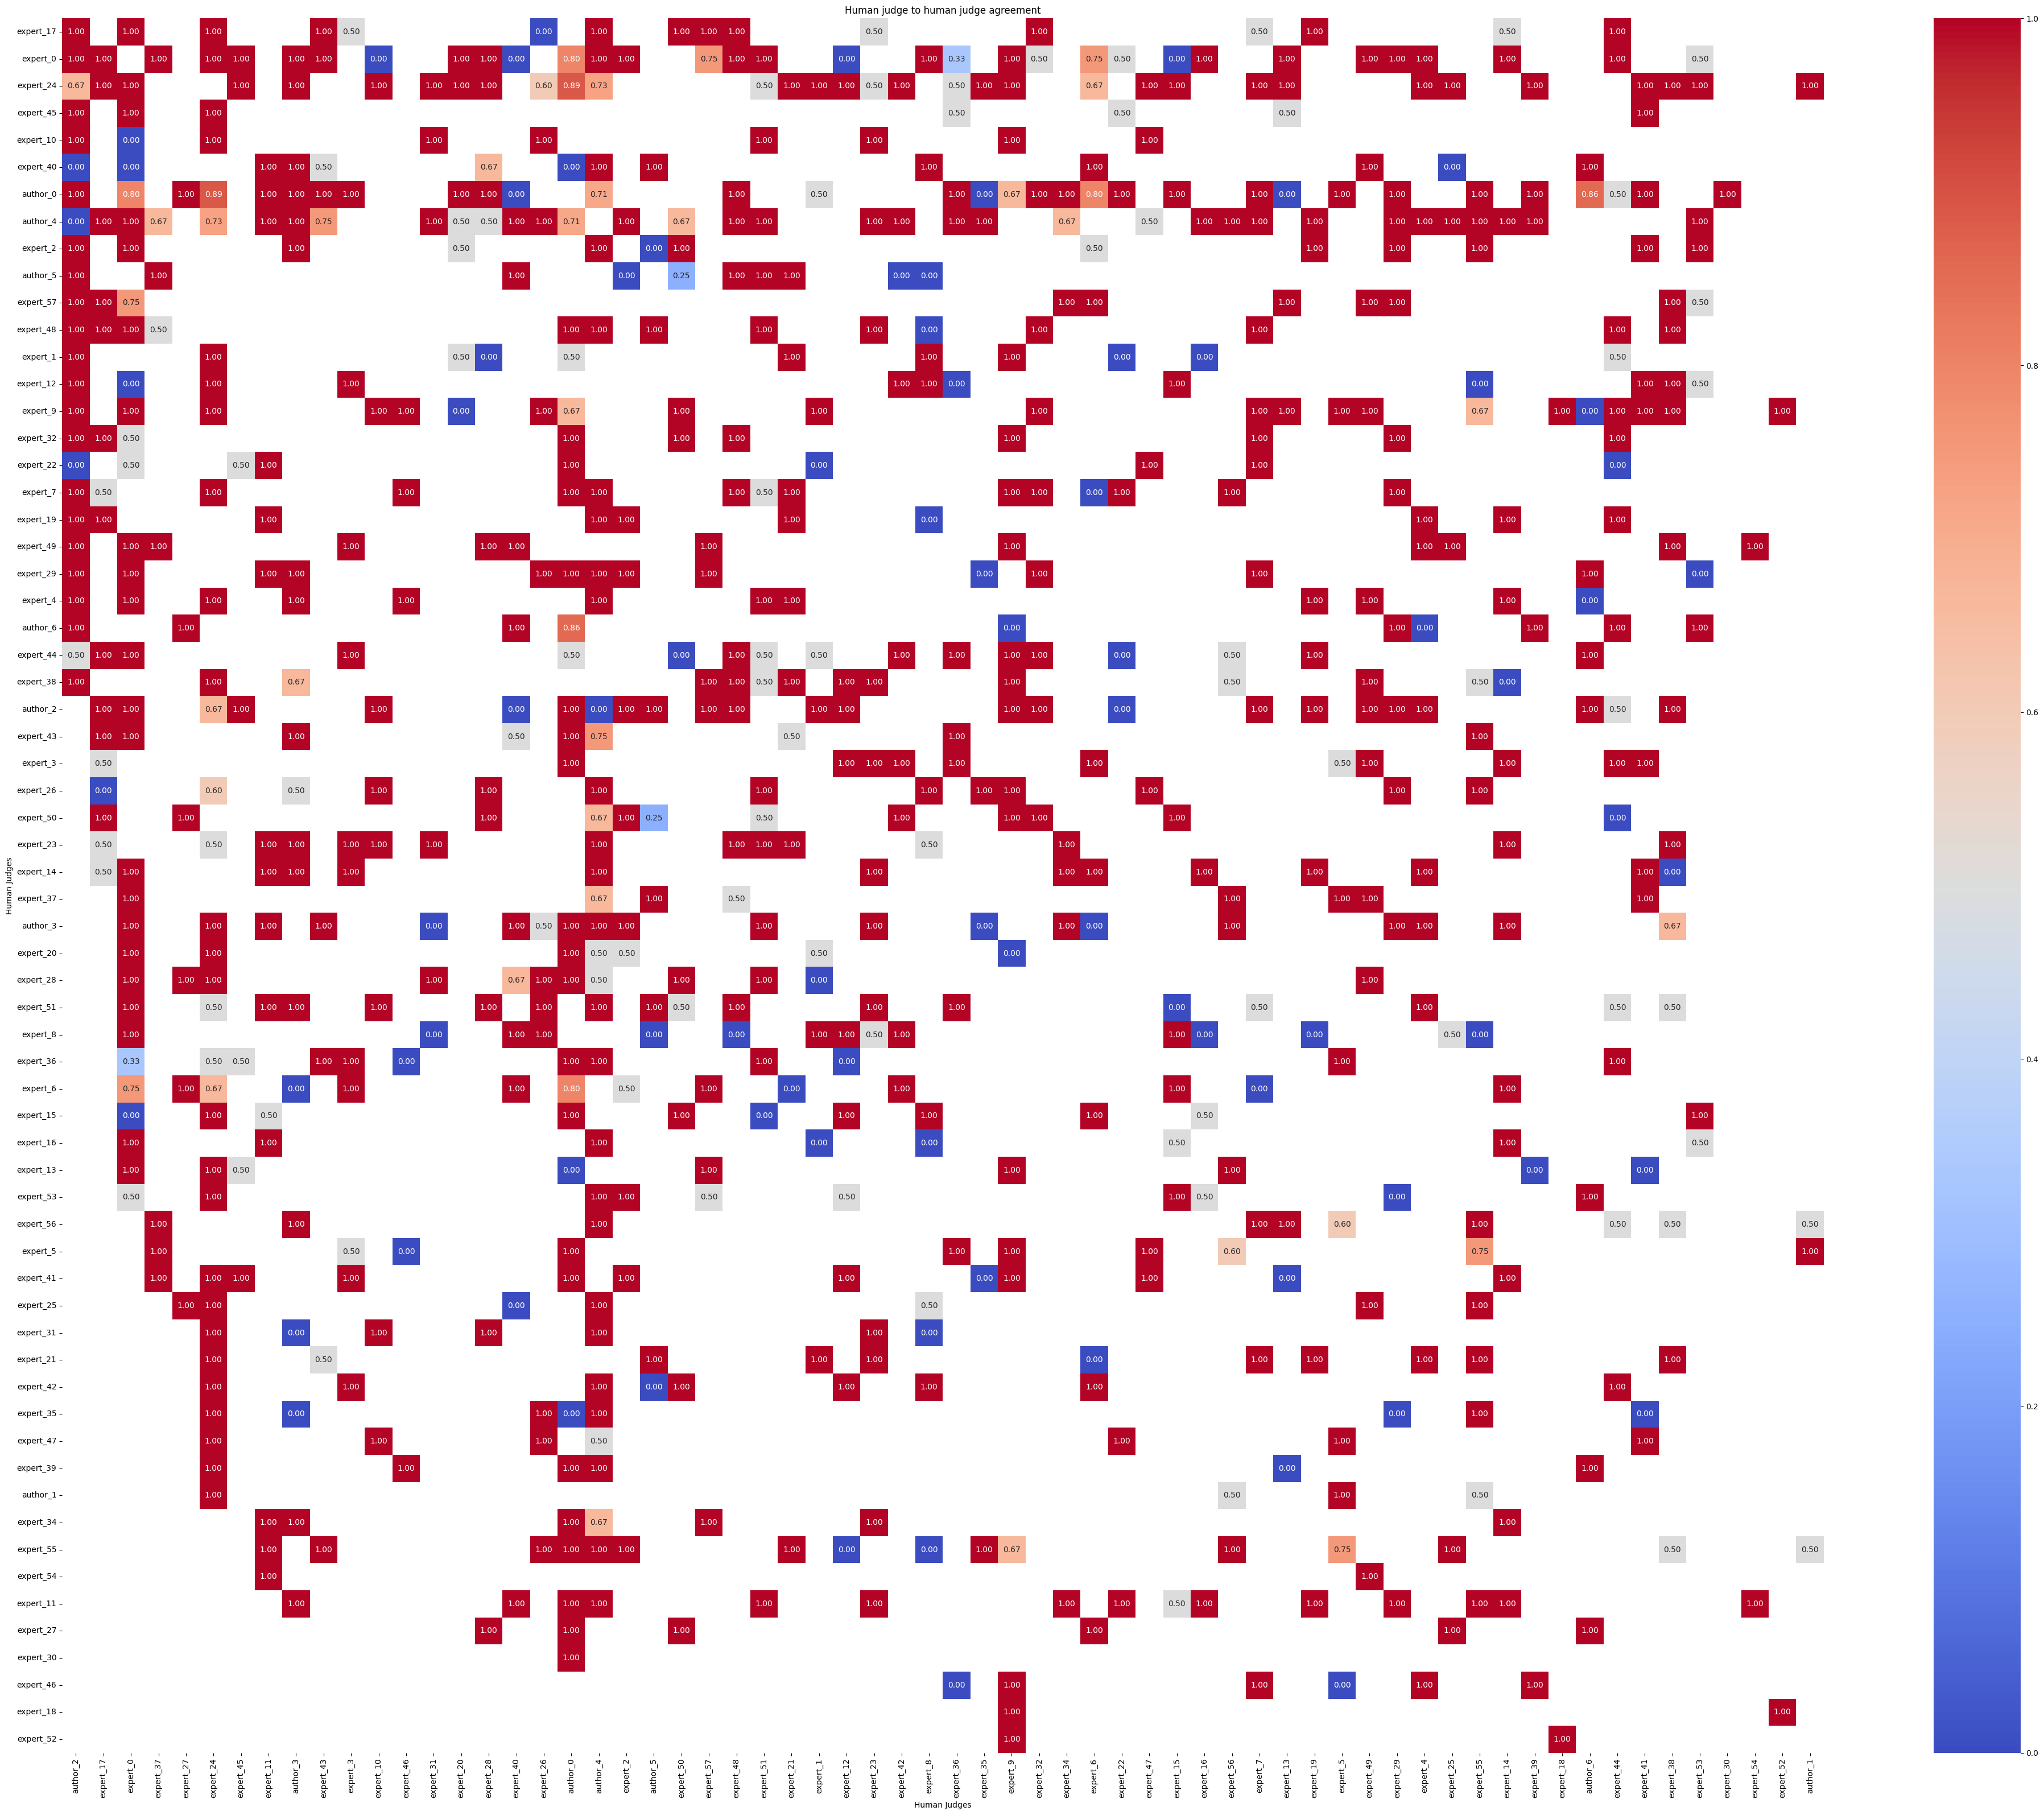

                0
count  786.000000
mean     0.813158
std      0.335295
min      0.000000
25%      0.666667
50%      1.000000
75%      1.000000
max      1.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

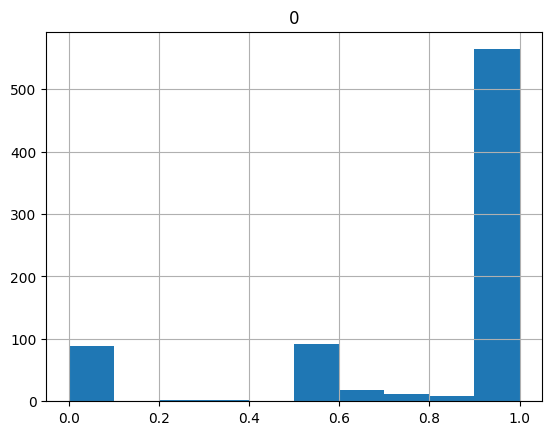

In [35]:
# 'expert_44': {(92, 1, 'gpt-3.5-turbo', 'alpaca-13b'): 'model_a',
#               (92, 2, 'gpt-3.5-turbo', 'alpaca-13b'): 'model_b',
#               (93, 1, 'gpt-4', 'vicuna-13b-v1.2'): 'model_a',

judge_to_votes_map = defaultdict(dict)
for i, row in df.iterrows():
    if row["winner"] != "tie":
        judge_to_votes_map[row["judge"]][(row["question_id"], row["turn"], row["model_a"], row["model_b"])] = row["winner"]

def get_judge_to_judge_agreement(judge1_votes, judge2_votes):
    agreements = []
    judge1_vote_keys = set(judge1_votes.keys())
    judge2_vote_keys = set(judge2_votes.keys())

    both_judge_vote_keys = judge1_vote_keys & judge2_vote_keys

    if not both_judge_vote_keys:
        return None

    for judge_vote_key in both_judge_vote_keys:
        agreements.append(judge1_votes[judge_vote_key] == judge2_votes[judge_vote_key])

    return np.mean(agreements)

# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    for judge2 in df["judge"].unique():
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement


judge_to_judge_agreement_df = pd.DataFrame(judge_to_judge_agreement)

plt.figure(figsize=(40, 32))
sns.heatmap(
    judge_to_judge_agreement_df,
    annot=judge_to_judge_agreement_df,
    cmap="coolwarm",
    fmt=".2f",
    vmin=0,
    vmax=1,
)
plt.title("Human judge to human judge agreement")
plt.setp(plt.xticks()[1], rotation=90)
plt.ylabel("Human Judges")
plt.xlabel("Human Judges")
plt.tight_layout()
plt.show()


# Find the average agreement between two judges.

agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        agreements.append(agreement)

print(pd.DataFrame(agreements).describe())

pd.DataFrame(agreements).hist()

In [145]:
# 2575
# df[df["winner"] != "tie"]
# 780
df[df["winner"] == "tie"]

# Why exclude ties?

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn,conversation_a_num_tokens,conversation_b_num_tokens,color,token_diff,result_numeric
5,81,alpaca-13b,vicuna-13b-v1.2,tie,expert_0,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,2,146,750,yellow,-604,0
9,81,claude-v1,llama-13b,tie,expert_27,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,2,340,577,yellow,-237,0
14,81,gpt-3.5-turbo,claude-v1,tie,expert_11,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,1,171,340,yellow,-169,0
16,81,gpt-3.5-turbo,vicuna-13b-v1.2,tie,expert_24,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,1,171,750,yellow,-579,0
25,81,vicuna-13b-v1.2,llama-13b,tie,expert_0,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,2,750,577,yellow,173,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,160,gpt-4,vicuna-13b-v1.2,tie,expert_9,[{'content': 'Suggest five award-winning docum...,[{'content': 'Suggest five award-winning docum...,1,201,179,yellow,22,0
3336,160,gpt-4,vicuna-13b-v1.2,tie,expert_9,[{'content': 'Suggest five award-winning docum...,[{'content': 'Suggest five award-winning docum...,2,201,179,yellow,22,0
3345,160,vicuna-13b-v1.2,claude-v1,tie,expert_0,[{'content': 'Suggest five award-winning docum...,[{'content': 'Suggest five award-winning docum...,1,179,336,yellow,-157,0
3349,160,vicuna-13b-v1.2,gpt-3.5-turbo,tie,author_4,[{'content': 'Suggest five award-winning docum...,[{'content': 'Suggest five award-winning docum...,1,179,144,yellow,35,0


# Agreement within authors

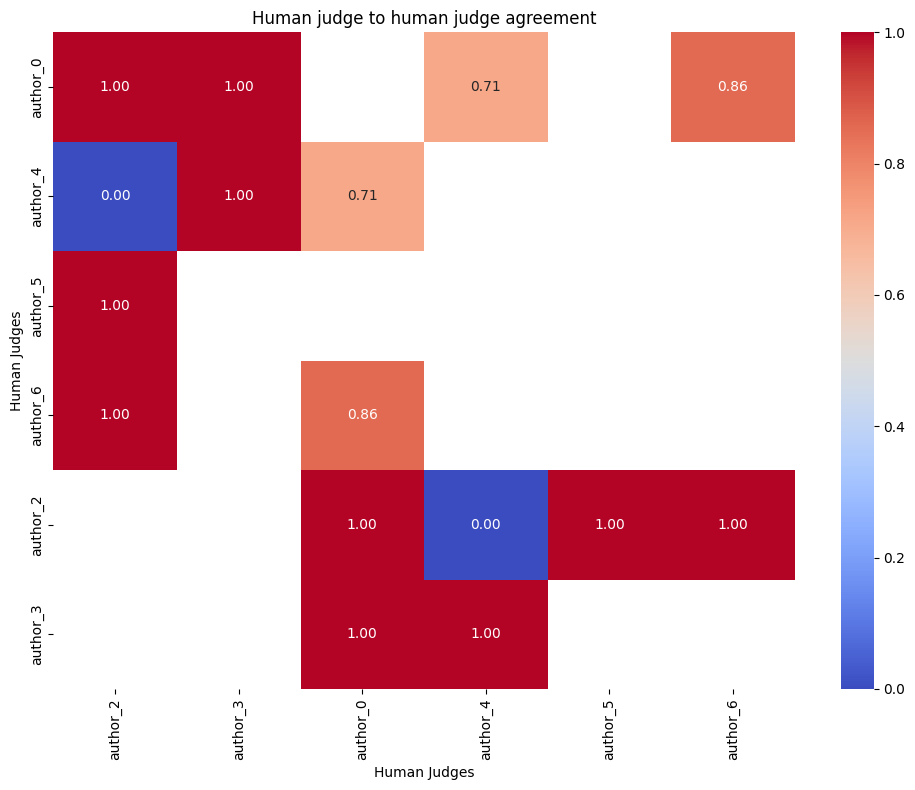

               0
count  16.000000
mean    0.821429
std     0.336043
min     0.000000
25%     0.821429
50%     1.000000
75%     1.000000
max     1.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

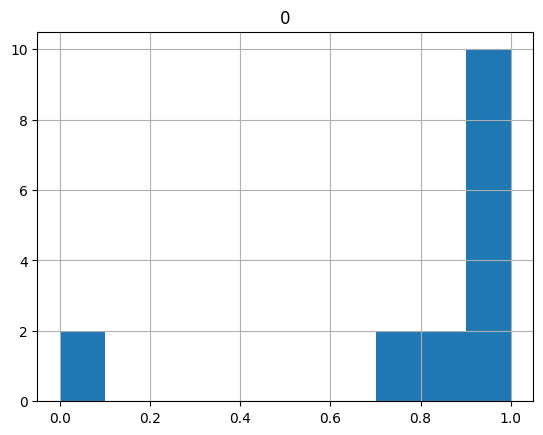

In [36]:
# 'expert_44': {(92, 1, 'gpt-3.5-turbo', 'alpaca-13b'): 'model_a',
#               (92, 2, 'gpt-3.5-turbo', 'alpaca-13b'): 'model_b',
#               (93, 1, 'gpt-4', 'vicuna-13b-v1.2'): 'model_a',

judge_to_votes_map = defaultdict(dict)
for i, row in df.iterrows():
    if row["winner"] != "tie":
        judge_to_votes_map[row["judge"]][(row["question_id"], row["turn"], row["model_a"], row["model_b"])] = row["winner"]

def get_judge_to_judge_agreement(judge1_votes, judge2_votes):
    agreements = []
    judge1_vote_keys = set(judge1_votes.keys())
    judge2_vote_keys = set(judge2_votes.keys())

    both_judge_vote_keys = judge1_vote_keys & judge2_vote_keys

    if not both_judge_vote_keys:
        return None

    for judge_vote_key in both_judge_vote_keys:
        agreements.append(judge1_votes[judge_vote_key] == judge2_votes[judge_vote_key])

    return np.mean(agreements)

# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    if "author" not in judge1:
        continue
    for judge2 in df["judge"].unique():
        if "author" not in judge2:
            continue
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement


judge_to_judge_agreement_df = pd.DataFrame(judge_to_judge_agreement)

plt.figure(figsize=(10, 8))
sns.heatmap(
    judge_to_judge_agreement_df,
    annot=judge_to_judge_agreement_df,
    cmap="coolwarm",
    fmt=".2f",
    vmin=0,
    vmax=1,
)
plt.title("Human judge to human judge agreement")
plt.setp(plt.xticks()[1], rotation=90)
plt.ylabel("Human Judges")
plt.xlabel("Human Judges")
plt.tight_layout()
plt.show()


# Find the average agreement between two judges.

agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        agreements.append(agreement)

print(pd.DataFrame(agreements).describe())

pd.DataFrame(agreements).hist()

# Author agreement, with ties

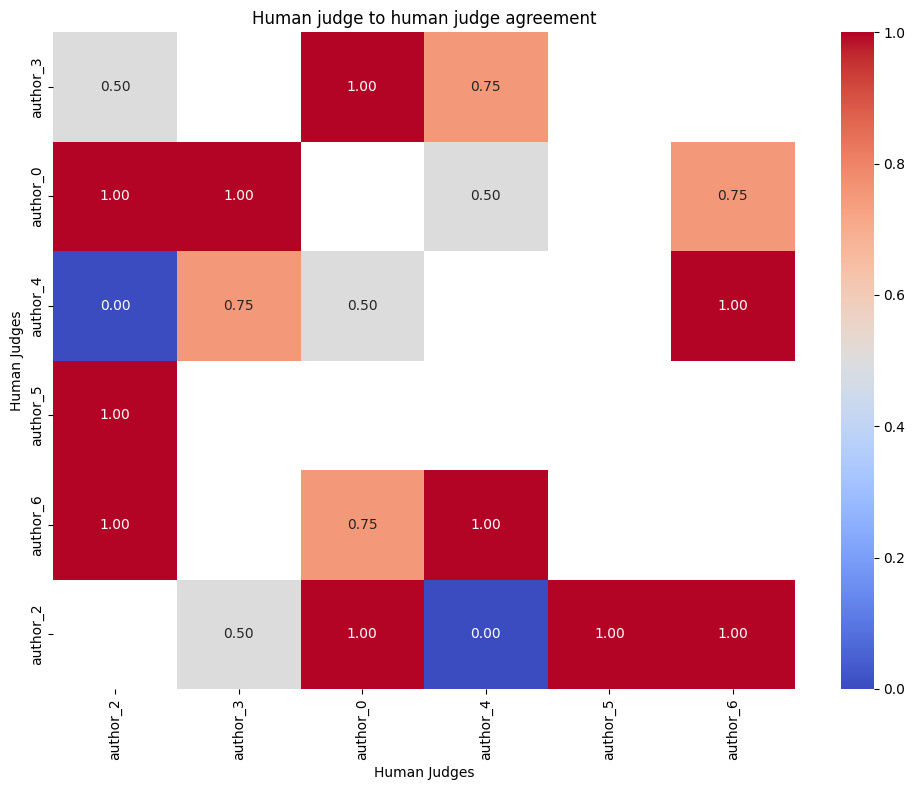

               0
count  20.000000
mean    0.750000
std     0.324443
min     0.000000
25%     0.500000
50%     0.875000
75%     1.000000
max     1.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

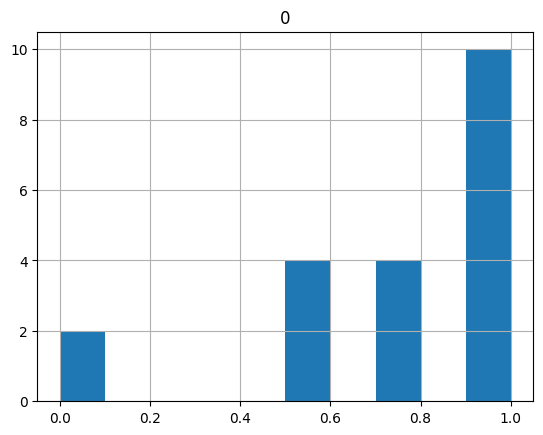

In [37]:
# 'expert_44': {(92, 1, 'gpt-3.5-turbo', 'alpaca-13b'): 'model_a',
#               (92, 2, 'gpt-3.5-turbo', 'alpaca-13b'): 'model_b',
#               (93, 1, 'gpt-4', 'vicuna-13b-v1.2'): 'model_a',

judge_to_votes_map = defaultdict(dict)
for i, row in df.iterrows():
    # if row["winner"] != "tie":
    judge_to_votes_map[row["judge"]][(row["question_id"], row["turn"], row["model_a"], row["model_b"])] = row["winner"]

def get_judge_to_judge_agreement(judge1_votes, judge2_votes):
    agreements = []
    judge1_vote_keys = set(judge1_votes.keys())
    judge2_vote_keys = set(judge2_votes.keys())

    both_judge_vote_keys = judge1_vote_keys & judge2_vote_keys

    if not both_judge_vote_keys:
        return None

    for judge_vote_key in both_judge_vote_keys:
        agreements.append(judge1_votes[judge_vote_key] == judge2_votes[judge_vote_key])

    return np.mean(agreements)

# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    if "author" not in judge1:
        continue
    for judge2 in df["judge"].unique():
        if "author" not in judge2:
            continue
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement


judge_to_judge_agreement_df = pd.DataFrame(judge_to_judge_agreement)

plt.figure(figsize=(10, 8))
sns.heatmap(
    judge_to_judge_agreement_df,
    annot=judge_to_judge_agreement_df,
    cmap="coolwarm",
    fmt=".2f",
    vmin=0,
    vmax=1,
)
plt.title("Human judge to human judge agreement")
plt.setp(plt.xticks()[1], rotation=90)
plt.ylabel("Human Judges")
plt.xlabel("Human Judges")
plt.tight_layout()
plt.show()


# Find the average agreement between two judges.

agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        agreements.append(agreement)

print(pd.DataFrame(agreements).describe())

pd.DataFrame(agreements).hist()

# Non-author agreement

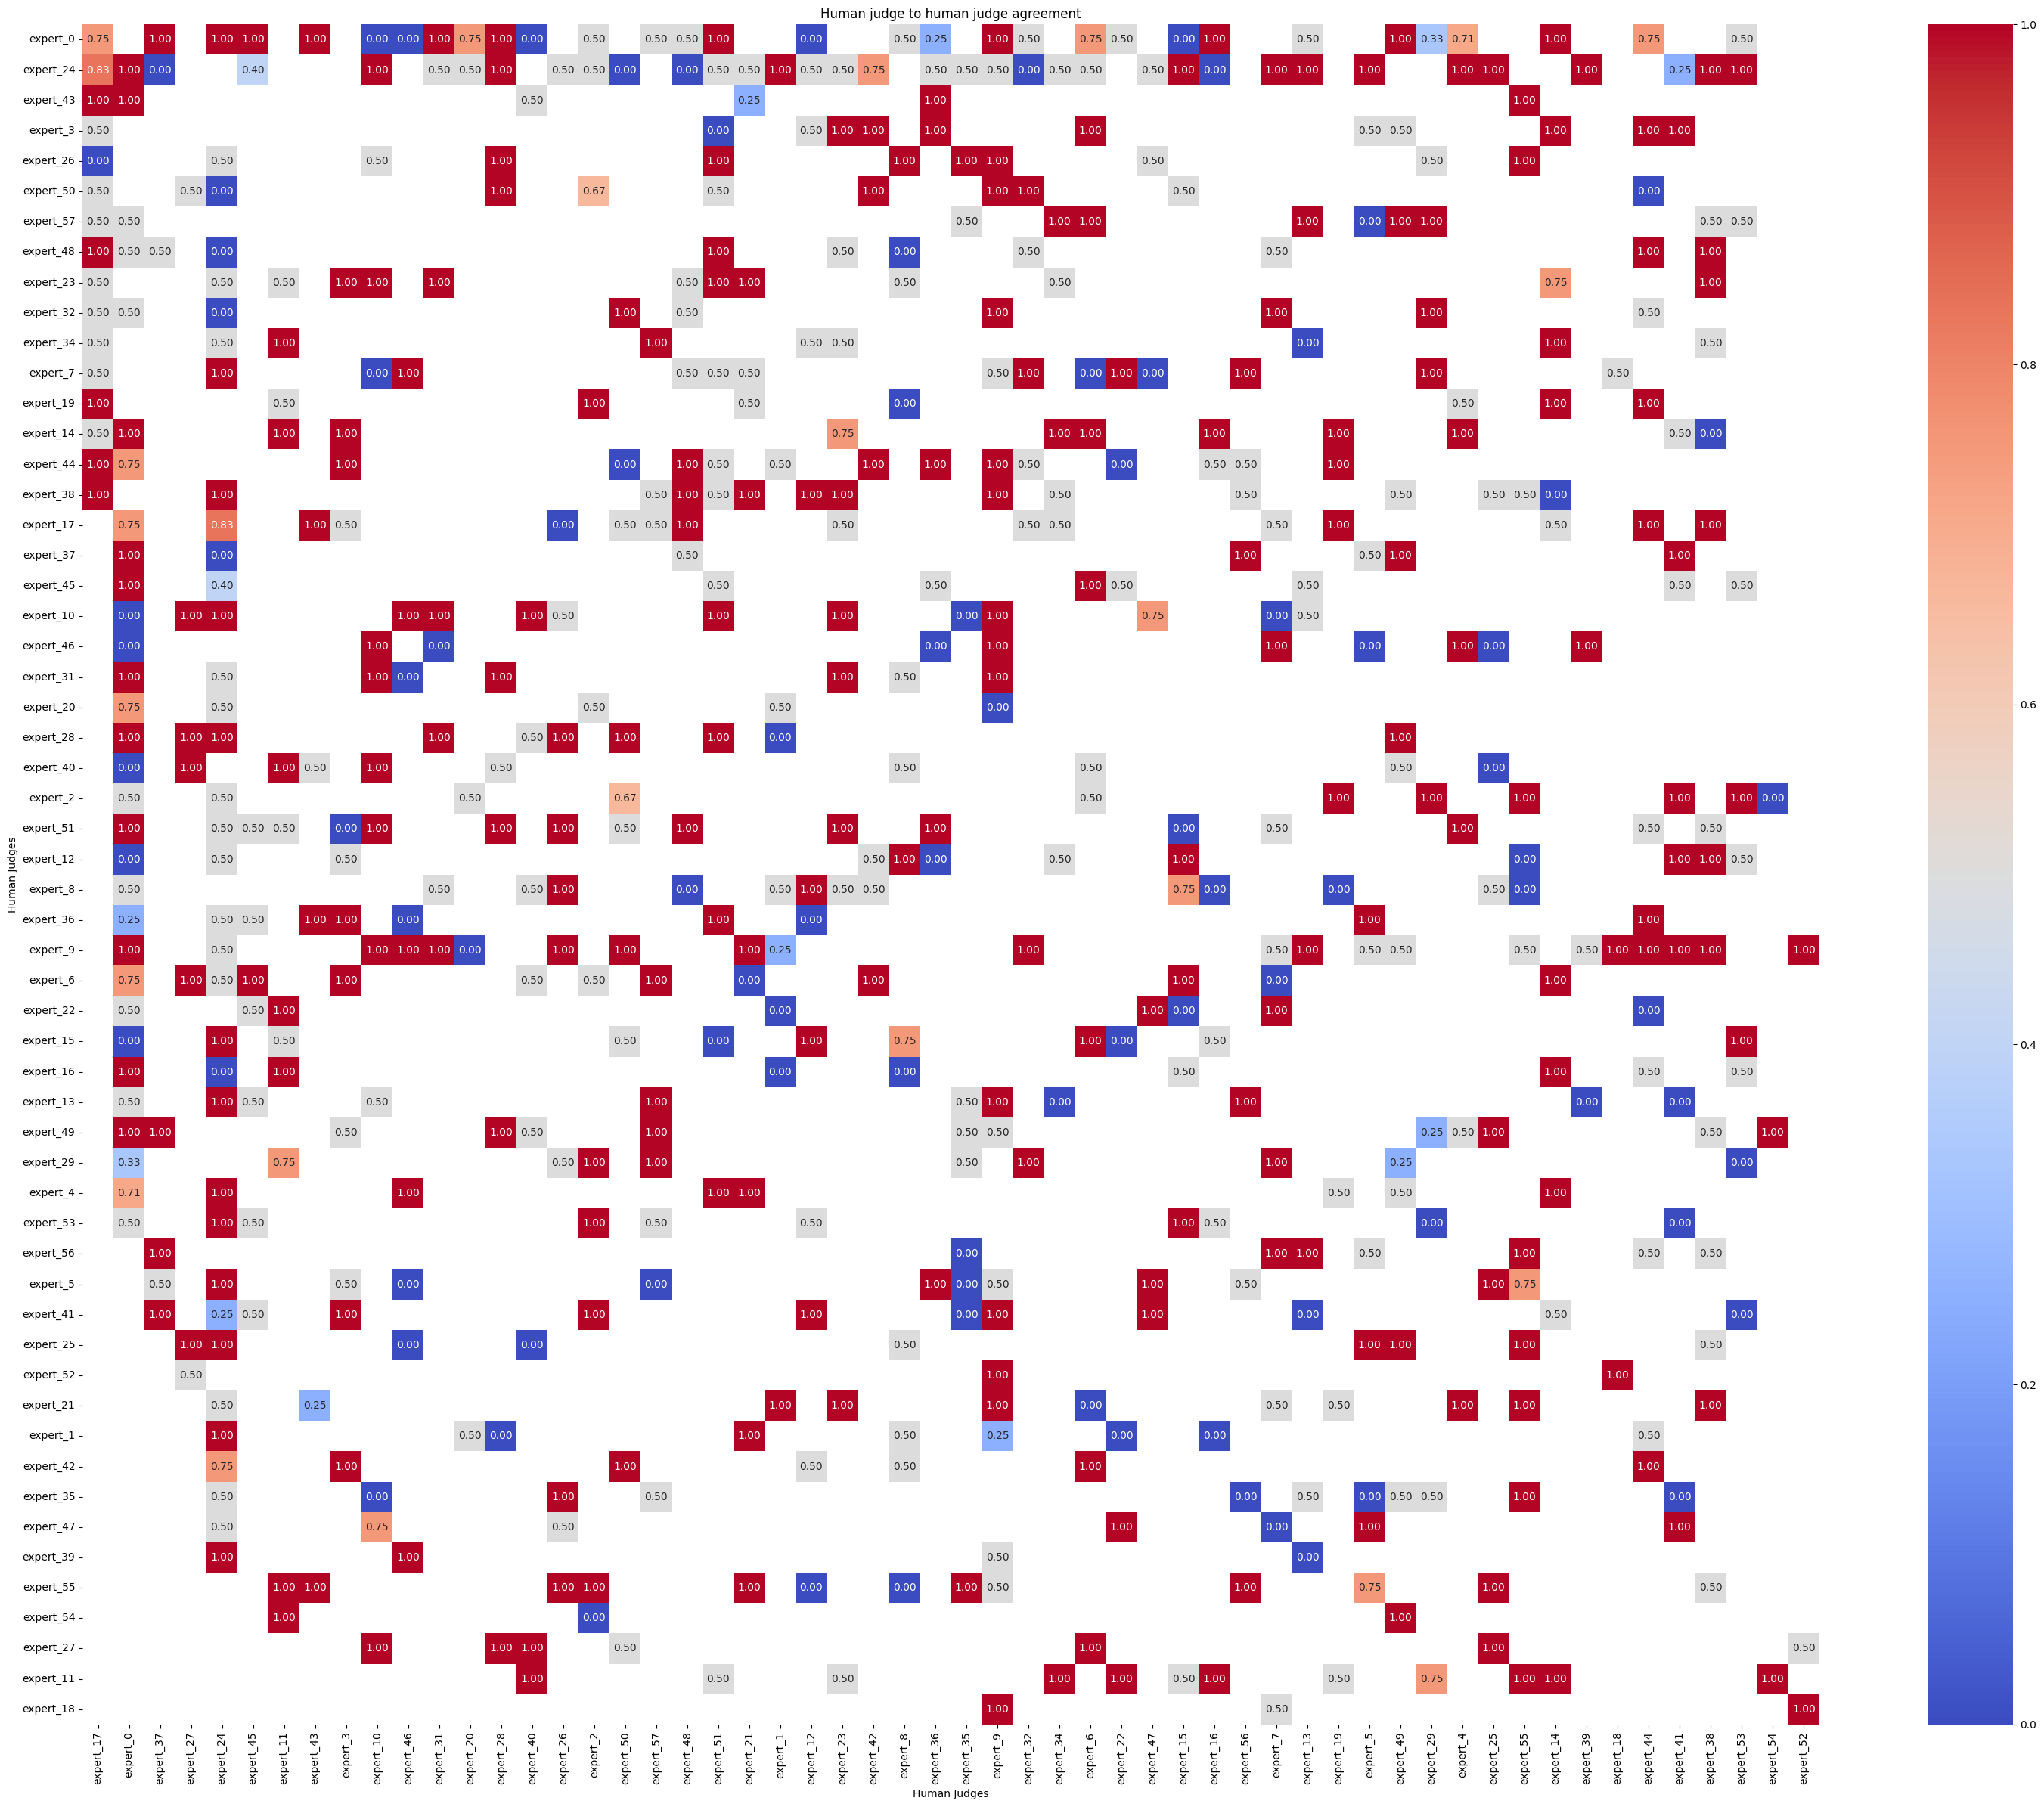

                0
count  624.000000
mean     0.654480
std      0.360419
min      0.000000
25%      0.500000
50%      0.500000
75%      1.000000
max      1.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

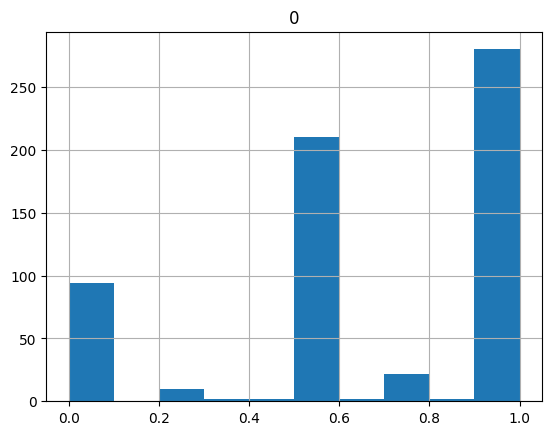

In [152]:
# 'expert_44': {(92, 1, 'gpt-3.5-turbo', 'alpaca-13b'): 'model_a',
#               (92, 2, 'gpt-3.5-turbo', 'alpaca-13b'): 'model_b',
#               (93, 1, 'gpt-4', 'vicuna-13b-v1.2'): 'model_a',

judge_to_votes_map = defaultdict(dict)
for i, row in df.iterrows():
    # if row["winner"] != "tie":
    judge_to_votes_map[row["judge"]][(row["question_id"], row["turn"], row["model_a"], row["model_b"])] = row["winner"]

def get_judge_to_judge_agreement(judge1_votes, judge2_votes):
    agreements = []
    judge1_vote_keys = set(judge1_votes.keys())
    judge2_vote_keys = set(judge2_votes.keys())

    both_judge_vote_keys = judge1_vote_keys & judge2_vote_keys

    if not both_judge_vote_keys:
        return None

    for judge_vote_key in both_judge_vote_keys:
        agreements.append(judge1_votes[judge_vote_key] == judge2_votes[judge_vote_key])

    return np.mean(agreements)

# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    if "author" in judge1:
        continue
    for judge2 in df["judge"].unique():
        if "author" in judge2:
            continue
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement


judge_to_judge_agreement_df = pd.DataFrame(judge_to_judge_agreement)

plt.figure(figsize=(30, 24))
sns.heatmap(
    judge_to_judge_agreement_df,
    annot=judge_to_judge_agreement_df,
    cmap="coolwarm",
    fmt=".2f",
    vmin=0,
    vmax=1,
)
plt.title("Human judge to human judge agreement")
plt.setp(plt.xticks()[1], rotation=90)
plt.ylabel("Human Judges")
plt.xlabel("Human Judges")
plt.tight_layout()
plt.show()


# Find the average agreement between two judges.

agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        agreements.append(agreement)

print(pd.DataFrame(agreements).describe())

pd.DataFrame(agreements).hist()

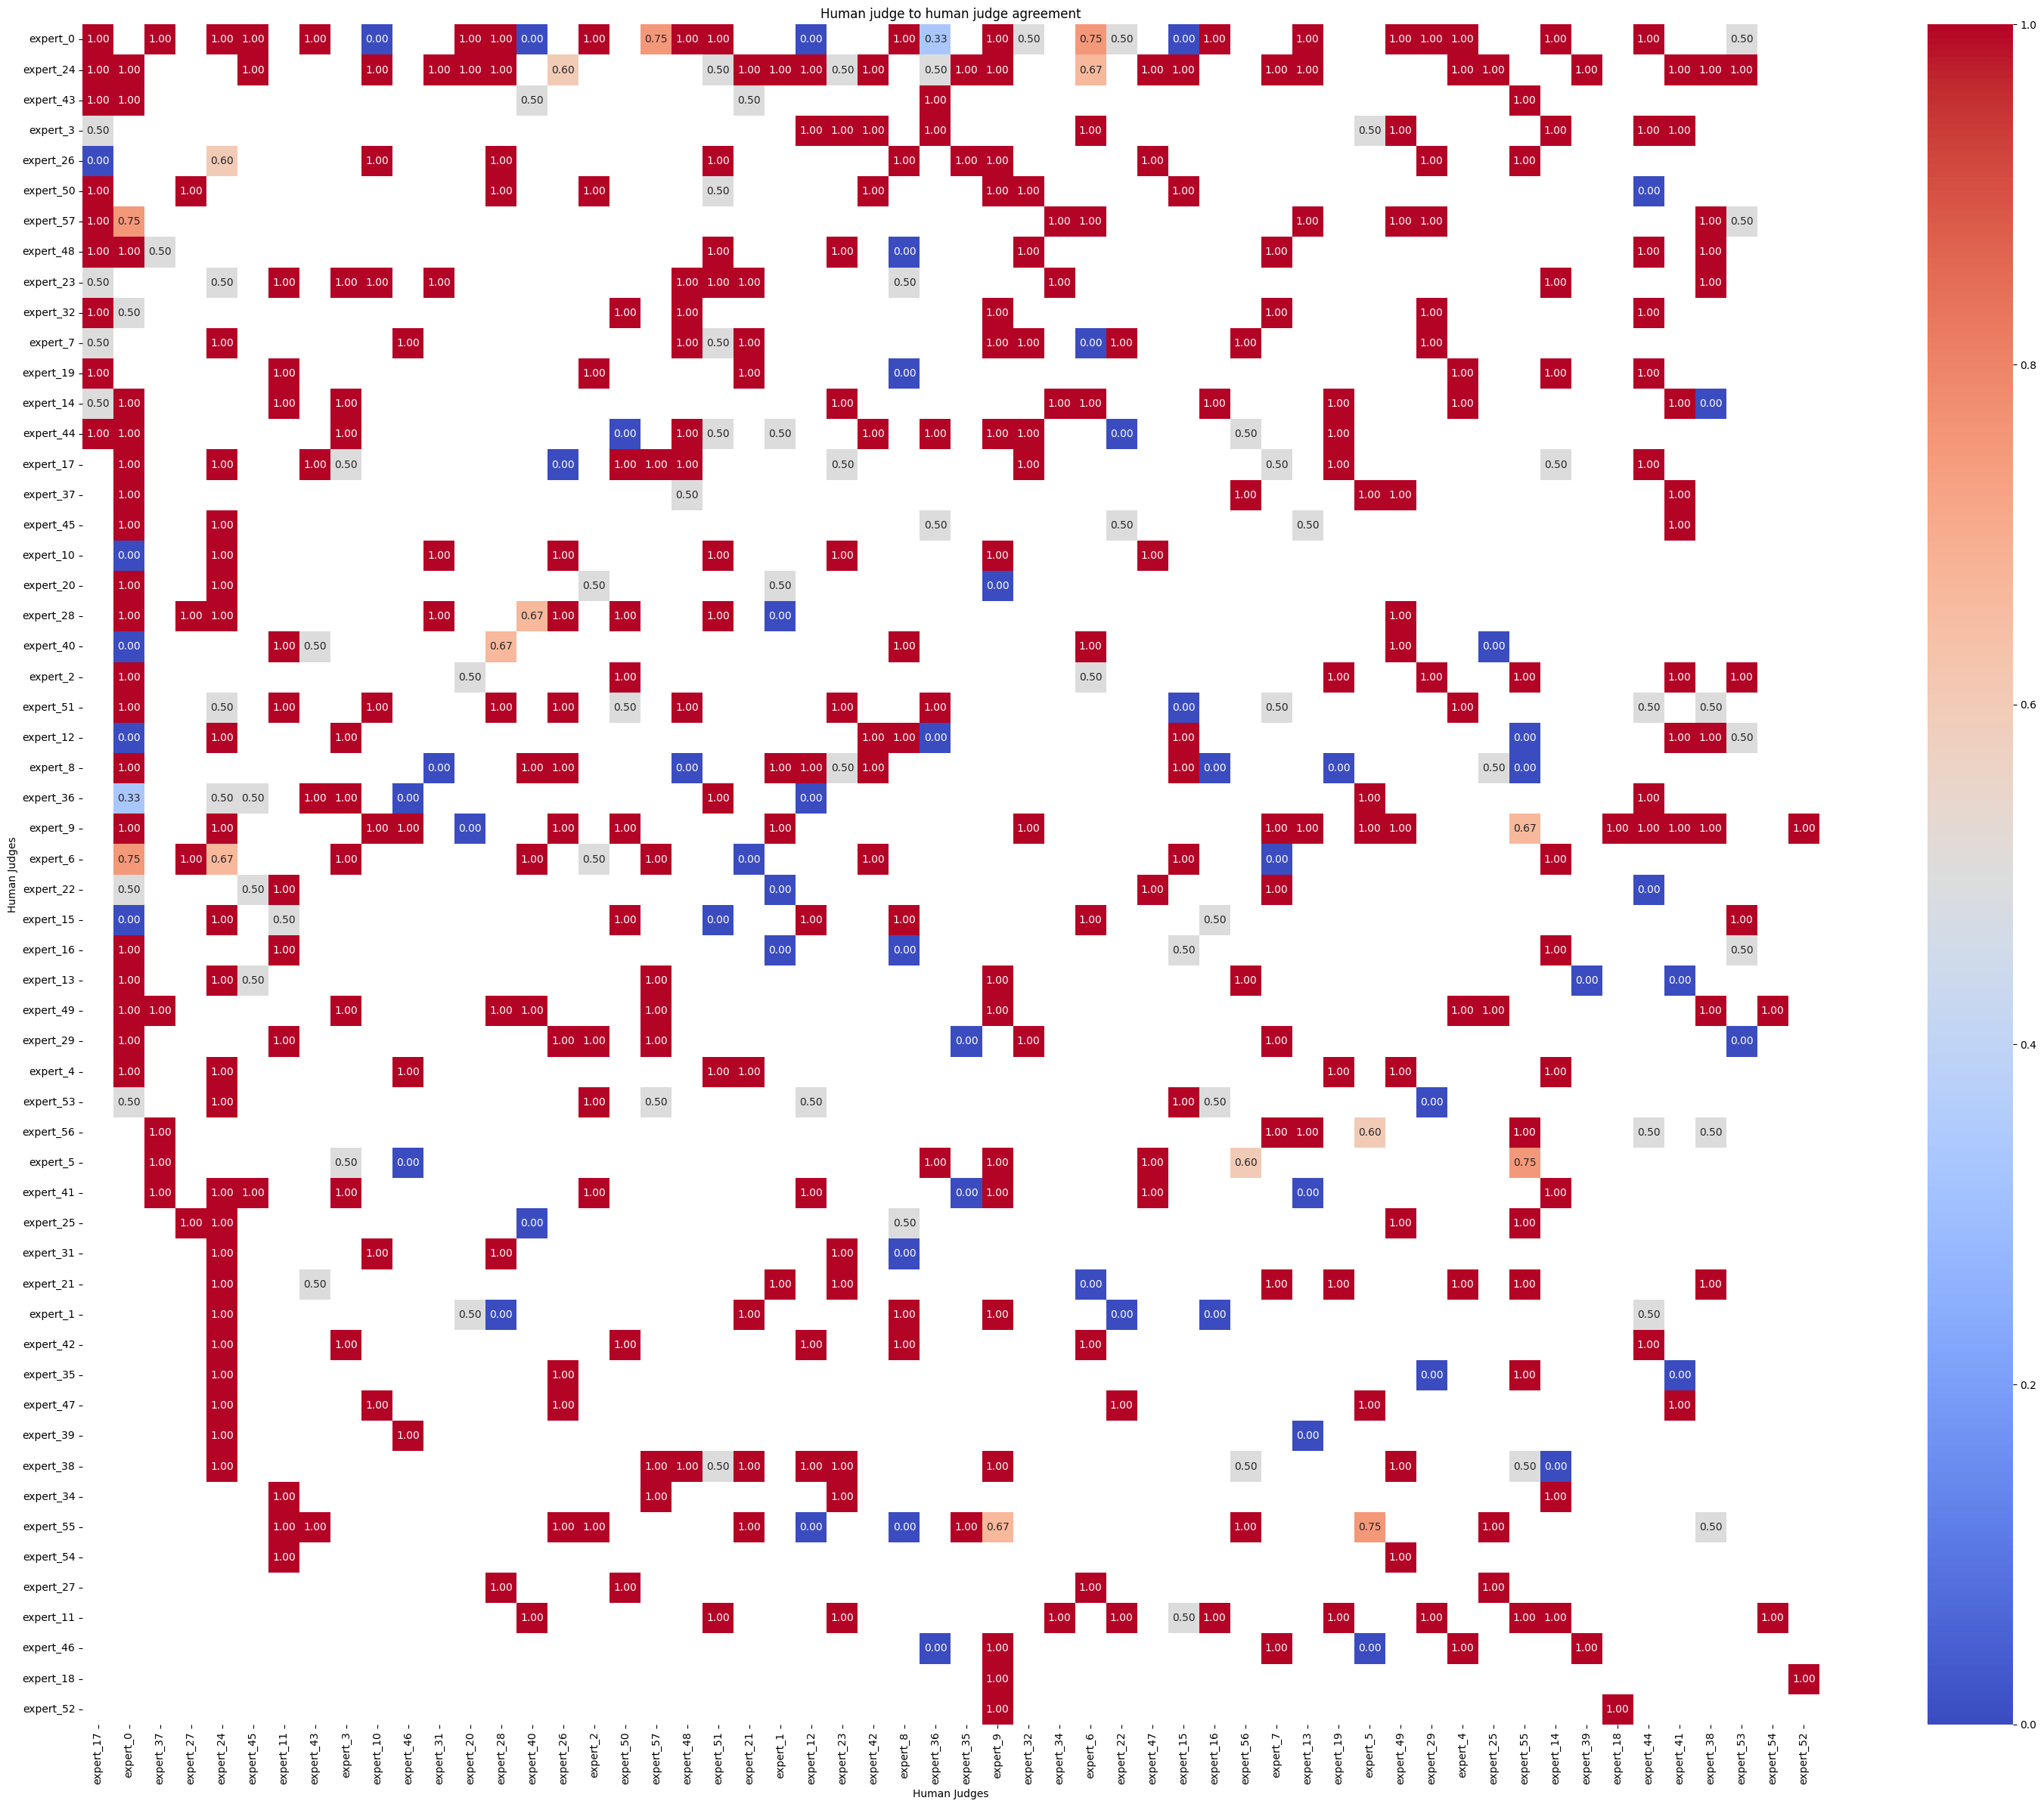

                0
count  530.000000
mean     0.808616
std      0.338622
min      0.000000
25%      0.600000
50%      1.000000
75%      1.000000
max      1.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

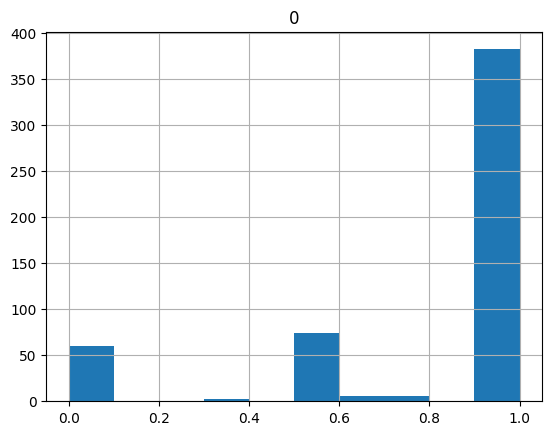

In [153]:
# 'expert_44': {(92, 1, 'gpt-3.5-turbo', 'alpaca-13b'): 'model_a',
#               (92, 2, 'gpt-3.5-turbo', 'alpaca-13b'): 'model_b',
#               (93, 1, 'gpt-4', 'vicuna-13b-v1.2'): 'model_a',

judge_to_votes_map = defaultdict(dict)
for i, row in df.iterrows():
    if row["winner"] != "tie":
        judge_to_votes_map[row["judge"]][(row["question_id"], row["turn"], row["model_a"], row["model_b"])] = row["winner"]

def get_judge_to_judge_agreement(judge1_votes, judge2_votes):
    agreements = []
    judge1_vote_keys = set(judge1_votes.keys())
    judge2_vote_keys = set(judge2_votes.keys())

    both_judge_vote_keys = judge1_vote_keys & judge2_vote_keys

    if not both_judge_vote_keys:
        return None

    for judge_vote_key in both_judge_vote_keys:
        agreements.append(judge1_votes[judge_vote_key] == judge2_votes[judge_vote_key])

    return np.mean(agreements)

# judge -> judge -> agreement (float)
judge_to_judge_agreement = defaultdict(dict)
for judge1 in df["judge"].unique():
    if "author" in judge1:
        continue
    for judge2 in df["judge"].unique():
        if "author" in judge2:
            continue
        if judge1 == judge2:
            continue
        judge1_votes = judge_to_votes_map[judge1]
        judge2_votes = judge_to_votes_map[judge2]

        agreement = get_judge_to_judge_agreement(judge1_votes, judge2_votes)
        if agreement is not None:
            judge_to_judge_agreement[judge1][judge2] = agreement


judge_to_judge_agreement_df = pd.DataFrame(judge_to_judge_agreement)

plt.figure(figsize=(30, 24))
sns.heatmap(
    judge_to_judge_agreement_df,
    annot=judge_to_judge_agreement_df,
    cmap="coolwarm",
    fmt=".2f",
    vmin=0,
    vmax=1,
)
plt.title("Human judge to human judge agreement")
plt.setp(plt.xticks()[1], rotation=90)
plt.ylabel("Human Judges")
plt.xlabel("Human Judges")
plt.tight_layout()
plt.show()


# Find the average agreement between two judges.

agreements = []
for judge, other_judge_agreement in judge_to_judge_agreement.items():
    for other_judge, agreement in other_judge_agreement.items():
        agreements.append(agreement)

print(pd.DataFrame(agreements).describe())

pd.DataFrame(agreements).hist()

# Comparison to other leaderboards

In [303]:
df = pd.read_csv("/Users/justinzhao/Downloads/compare_leaderboards.csv")

In [306]:
# find the spearman correlation between
# df
# Pivot the dataframe
pivot_df = df.pivot(index='LLM', columns='System', values='Score')
# Calculate the Spearman correlation
spearman_corr = pivot_df.corr(method='spearman')

print(spearman_corr)

System         Chatbot Arena  EQ-Bench  Human Study  LMC (EI)      MMLU
System                                                                 
Chatbot Arena       1.000000  0.550000     0.483333  0.483333  0.933333
EQ-Bench            0.550000  1.000000     0.383333  0.683333  0.716667
Human Study         0.483333  0.383333     1.000000  0.883333  0.650000
LMC (EI)            0.483333  0.683333     0.883333  1.000000  0.683333
MMLU                0.933333  0.716667     0.650000  0.683333  1.000000


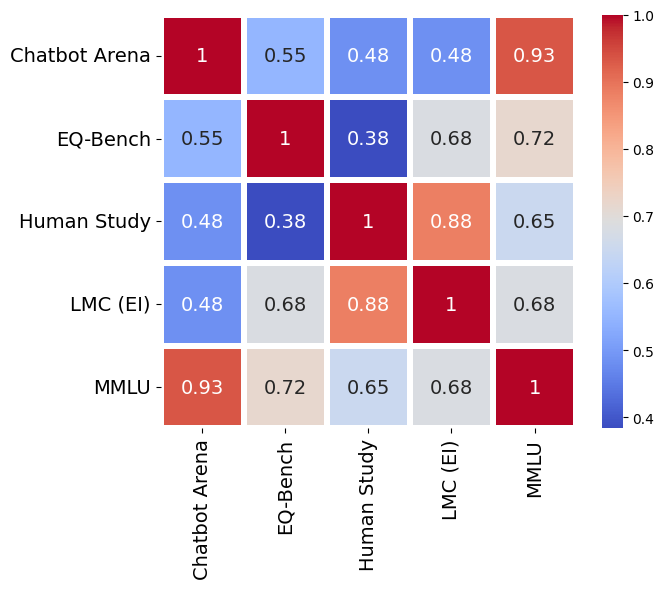

In [307]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', linewidths=3, annot_kws={"size": 14})
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)
# plt.title('Spearman Correlation Heatmap')
plt.tight_layout()
plt.savefig("/Users/justinzhao/Repos/llm-council/experiments/expansion.5_26/human_ratings/spearman_with_other_leaderboards.pdf")
plt.show()